# Оценка риска ДТП по выбранному маршруту движения.

### Описание проекта.
Нужно создать систему, которая могла бы оценить риск ДТП по выбранному маршруту движения. Под риском понимается вероятность ДТП с любым повреждением транспортного средства. Как только водитель забронировал автомобиль, сел за руль и выбрал маршрут, система должна оценить уровень риска. Если уровень риска высок, водитель увидит предупреждение и рекомендации по маршруту.

### Цель
Создать модель предсказания ДТП.

### Задачи:
1. Загрузить таблицы sql.
2. Провести первичное исследование таблиц, используя sql-запрос.
3. Провести статистический анализ факторов ДТП.
- поставить задачи коллегам
- прописать порядок решения задач
4. Создайть модель для оценки водительского риска.
- Подготовить набор данных на основе первичного предположения заказчика.
- Провести первичный отбор факторов, необходимых для модели.
- Провести статистическое исследование отобранных факторов.
5. Найти лучшую модель.
6. Проверить лучшую модель в работе.
- проведите графический анализ «Матрица ошибок».
- проанализировать важность основных факторов, влияющих на вероятность ДТП.
- для одного из выявленных важных факторов проведите дополнительное исследование.
7. Сделайте общий вывод по модели.

План проведения исследования совпадает с задачами проекта.

### Исходные данные.
Таблицы:
 - collisions — общая информация о ДТП. Имеет уникальный case_id. Эта таблица описывает общую информацию о ДТП. Например, где оно произошло и когда.
 - parties — информация об участниках ДТП. Имеет неуникальный case_id, который сопоставляется с соответствующим ДТП в таблице collisions. Каждая строка здесь описывает одну из сторон, участвующих в ДТП. Если столкнулись две машины, в этой таблице должно быть две строки с совпадением case_id. Если нужен уникальный идентификатор, это case_id and party_number.
 - vehicles — информация о пострадавших машинах. Имеет неуникальные case_id и неуникальные party_number, которые сопоставляются с таблицей collisions и таблицей parties. Если нужен уникальный идентификатор, это case_id and party_number.

## Подключитесь к базе. Загрузите таблицы sql

### Загрузка библиотек, установка констант

In [128]:
!pip install phik -q

##!pip show catboost -q
!pip install catboost q
!pip uninstall -y scikit-learn -q
!pip install scikit-learn==1.5.2 -q
!pip install category_encoders -q
!pip install torchmetrics -q


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.8.1 requires scikit-learn>=1.6.0, but you have scikit-learn 1.5.2 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sklearn-compat 0.1.3 requires scikit-learn<1.7,>=1.2, but you have scikit-learn 1.7.0 which is incompatible.


In [129]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import time
import numpy as np
import seaborn as sns
import phik
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchmetrics
import random
import pickle
import shap


from sqlalchemy import create_engine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, KFold
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score,  make_scorer, recall_score
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV
from category_encoders import TargetEncoder
from math import ceil
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import PolynomialFeatures

In [130]:
start_1 = time.time() #засечем время выполнения программы

In [131]:
RANDOM_STATE = 42

plt.rcParams["figure.figsize"] = (10,8)


In [132]:
db_config = {
'user': 'praktikum_student', # имя пользователя,
'pwd': 'Sdf4$2;d-d30pp', # пароль,
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432, # порт подключения,
'db': 'data-science-vehicle-db' # название базы данных,
}

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

engine = create_engine(connection_string)

In [133]:
def neyr(x=42):
    random.seed(x)
    np.random.seed(x)
    torch.manual_seed(x)
    torch.cuda.manual_seed_all(x)
    return



### Загрузка таблиц

Создадим функцию для получения датафрэймов по запросу SQL и вывода их и информации по ним на экран.

In [134]:
def fun_sql(request_sql):
    data = pd.read_sql_query(request_sql,engine)
    display(data.head())

    return data

Проверим наличие таблиц в базе.

In [135]:
q = '''
SELECT table_name
FROM information_schema.tables
WHERE  table_name = 'collisions' OR table_name = 'vehicles' OR table_name = 'parties'
'''

In [136]:
  fun_sql(q)

,table_name
0,parties
1,collisions
2,vehicles


,table_name
0,parties
1,collisions
2,vehicles


Все таблицы в наличии.

In [137]:

query = '''
SELECT *
FROM case_ids
'''

In [138]:
query_veh = '''
SELECT v.id,
        v.case_id,
        v.party_number,
        v.vehicle_type,
        v.vehicle_transmission,
        v.vehicle_age
FROM vehicles AS v
INNER JOIN collisions AS c ON v.case_id = c.case_id
WHERE DATE_TRUNC('day', c.collision_date) >= '2012-01-01' AND DATE_TRUNC('day', c.collision_date) <= '2012-12-31'
'''

In [139]:
query_pat = '''
SELECT p.id,
       p.case_id,
       p.party_number,
       p.party_type,
       p.at_fault,
       p.insurance_premium,
       p.party_sobriety,
       p.party_drug_physical,
       p.cellphone_in_use
FROM parties AS p
INNER JOIN collisions AS c ON p.case_id = c.case_id
WHERE DATE_TRUNC('day', c.collision_date) >= '2012-01-01' AND DATE_TRUNC('day', c.collision_date) <= '2012-12-31'
'''

In [140]:
query_col = '''
SELECT *
FROM collisions
WHERE DATE_TRUNC('day', collision_date) >= '2012-01-01' AND DATE_TRUNC('day', collision_date) <= '2012-12-31'
'''

In [141]:
case_ids_df = fun_sql(query)

,case_id,db_year
0,0081715,2021
1,0726202,2021
2,3858022,2021
3,3899441,2021
4,3899442,2021


In [142]:
case_ids_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400000 entries, 0 to 1399999
Data columns (total 2 columns):
 #   Column   Non-Null Count    Dtype 
---  ------   --------------    ----- 
 0   case_id  1400000 non-null  object
 1   db_year  1400000 non-null  object
dtypes: object(2)
memory usage: 21.4+ MB


Выгружена таблица, case_ids, которой не в описании, но есть в диаграмме.Состоит из двух столбцов и 1,4 млн строк с идентификаторами происшествий и каким-то годом. Данные имеют объектный тип.

Предполагаю, что эта таблица нам не понадобится.


In [143]:
vehicles_df = fun_sql(query_veh)


,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,1463705,5599671,2,sedan,auto,3.0
1,1463706,5599674,2,sedan,auto,10.0
2,1463709,5599677,2,sedan,auto,NaN
3,1463710,5599681,1,sedan,auto,0.0
4,1463713,5599684,2,sedan,auto,2.0


Запросом SQL в датафрэйм выгруженые данные только о тех машинах, происшествия с которыми произошли в 2012 г. согласно условию задачи.

In [144]:
collisions_df = fun_sql(query_col)

,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,4750401,0103,alameda,0.0,None,1.0,cloudy,None,scratch,2,vehicle code violation,traffic signals and signs,broadside,other motor vehicle,wet,normal,daylight,functioning,2012-04-10,13:47:00
1,5087612,3300,riverside,450.0,north,0.0,clear,ramp,scratch,2,vehicle code violation,dui,rear end,other motor vehicle,dry,normal,dark with street lights not functioning,none,2012-01-15,20:23:00
2,5125192,4312,santa clara,30.0,south,0.0,cloudy,None,small damage,2,vehicle code violation,unsafe starting or backing,other,parked motor vehicle,dry,normal,daylight,functioning,2012-03-16,14:35:00
3,5457328,3711,san diego,5.0,west,0.0,clear,None,middle damage,2,None,None,broadside,bicycle,dry,normal,daylight,none,2012-01-20,13:30:00
4,5403121,1919,los angeles,111.0,east,0.0,clear,highway,fatal,1,vehicle code violation,improper turning,hit object,other object,dry,normal,daylight,none,2012-01-05,15:52:00


In [145]:
perties_df = fun_sql(query_pat)

,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
0,2473241,5490711,3,road bumper,0,NaN,None,None,NaN
1,2656298,5599118,3,road bumper,0,NaN,None,None,NaN
2,2628600,5583730,2,road bumper,0,NaN,None,None,NaN
3,2662749,5603028,3,road bumper,0,NaN,None,None,NaN
4,2469249,5488558,2,road bumper,0,NaN,None,None,NaN


## Проведите первичное исследование таблиц

Создадим функцию для знакомства с данными.

In [146]:
def prep(df): #создадим функцию
    print(df.info())

    print ("Количество дубликатов:", df.duplicated().sum())

    print('Уникальные значения в столбцах (первые 50):')
    i=0
    for i in df.columns:
        try:
            print(f"  В столбце  {i}  такие уникальные значения:")
            print(df[i].sort_values().unique()[:50])
        except:
            print ('Похоже, ошибка в типе данных в столбце', i)
        print()
    j=0
    for j in df.columns:
        print (f"Доля пропусков в столбце {j} - {round(df[j].isna().sum()*100/df.shape[0],2)} %")
    return df.sample(5, random_state=RANDOM_STATE)

### collisions_df (общая информация о ДТП)

In [147]:
prep(collisions_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154547 entries, 0 to 154546
Data columns (total 20 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   case_id                      154547 non-null  object 
 1   county_city_location         154547 non-null  object 
 2   county_location              154547 non-null  object 
 3   distance                     154547 non-null  float64
 4   direction                    118511 non-null  object 
 5   intersection                 153637 non-null  float64
 6   weather_1                    153996 non-null  object 
 7   location_type                59406 non-null   object 
 8   collision_damage             154547 non-null  object 
 9   party_count                  154547 non-null  int64  
 10  primary_collision_factor     153859 non-null  object 
 11  pcf_violation_category       151456 non-null  object 
 12  type_of_collision            153217 non-null  object 
 13 

,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
7492,5503585,1942,los angeles,350.0,east,0.0,clear,highway,scratch,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,dry,normal,daylight,none,2012-01-03,15:10:00
65127,5525298,0708,contra costa,0.0,None,1.0,cloudy,None,small damage,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,daylight,functioning,2012-01-30,16:06:00
73899,5543048,3394,riverside,264.0,west,0.0,clear,None,small damage,2,other than driver,other than driver (or pedestrian),sideswipe,other motor vehicle,dry,normal,dark with street lights,functioning,2012-03-11,23:50:00
39786,5458334,1975,los angeles,300.0,east,0.0,clear,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,dry,normal,daylight,none,2012-01-08,14:45:00
13592,5534693,4803,solano,528.0,east,0.0,clear,None,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,daylight,functioning,2012-03-12,18:10:00


#### Дубликаты.

In [148]:
collisions_df['case_id'].duplicated().sum()

np.int64(0)

In [149]:
collisions_df.drop('case_id', axis=1).duplicated().sum()

np.int64(15)

In [150]:
collisions_df_case = collisions_df.drop('case_id', axis=1) #датасет без идентификатора ДТП

In [151]:

collisions_df.query('@collisions_df_case.duplicated() == True')

,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
22161,5589619,1942,los angeles,0.0,None,1.0,clear,None,scratch,2,vehicle code violation,traffic signals and signs,broadside,other motor vehicle,dry,normal,daylight,functioning,2012-03-12,14:30:00
26174,5614976,5607,ventura,3.0,north,0.0,clear,ramp,scratch,3,unknown,unknown,other,bicycle,dry,normal,daylight,functioning,2012-04-14,18:30:00
38051,5512700,3019,orange,20.0,east,0.0,cloudy,None,severe damage,2,vehicle code violation,dui,head-on,other motor vehicle,wet,normal,dark with street lights,none,2012-01-21,04:25:00
38211,5525884,5002,stanislaus,1763.0,west,0.0,clear,None,severe damage,1,vehicle code violation,improper turning,hit object,fixed object,dry,normal,dark with no street lights,none,2012-02-17,23:15:00
38777,5457313,1942,los angeles,0.0,None,1.0,clear,None,scratch,2,vehicle code violation,traffic signals and signs,head-on,other motor vehicle,dry,normal,daylight,functioning,2012-01-19,07:55:00
48848,5489451,1500,kern,0.0,None,1.0,clear,None,small damage,2,vehicle code violation,traffic signals and signs,broadside,other motor vehicle,dry,normal,daylight,functioning,2012-02-03,14:50:00
55591,5504993,2700,monterey,1056.0,north,0.0,cloudy,highway,small damage,1,vehicle code violation,speeding,hit object,other object,wet,obstruction,dark with no street lights,none,2012-01-21,01:45:00
65891,5527253,1941,los angeles,83.0,south,0.0,clear,None,small damage,1,vehicle code violation,dui,head-on,fixed object,dry,normal,dark with street lights,functioning,2012-03-12,01:46:00
72425,5539696,1954,los angeles,0.0,None,1.0,clear,None,small damage,2,vehicle code violation,traffic signals and signs,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2012-03-18,23:00:00
89532,5583047,1942,los angeles,300.0,south,0.0,clear,None,small damage,1,unknown,unknown,hit object,fixed object,dry,normal,dark with no street lights,none,2012-04-01,04:40:00


#### Значения столбцов, в которых много значений.

In [152]:
collisions_df['case_id'].sort_values().unique()

array(['4750401', '5064690', '5087612', ..., '5668367', '5668368',
       '5668369'], dtype=object)

In [153]:

collisions_df['county_city_location'].sort_values().unique()

array(['0100', '0101', '0102', '0103', '0104', '0105', '0106', '0107',
       '0108', '0109', '0110', '0111', '0112', '0113', '0198', '0200',
       '0300', '0301', '0302', '0303', '0304', '0305', '0400', '0401',
       '0402', '0403', '0404', '0405', '0500', '0501', '0600', '0601',
       '0602', '0700', '0701', '0702', '0703', '0704', '0705', '0706',
       '0707', '0708', '0709', '0710', '0711', '0712', '0713', '0714',
       '0715', '0716', '0734', '0790', '0791', '0792', '0800', '0801',
       '0900', '0901', '0902', '1000', '1001', '1002', '1003', '1004',
       '1005', '1007', '1008', '1009', '1010', '1011', '1012', '1013',
       '1014', '1015', '1100', '1101', '1102', '1200', '1201', '1203',
       '1205', '1300', '1301', '1302', '1304', '1305', '1306', '1400',
       '1401', '1500', '1501', '1502', '1503', '1504', '1505', '1506',
       '1507', '1508', '1509', '1510', '1511', '1515', '1600', '1601',
       '1602', '1603', '1690', '1700', '1701', '1702', '1800', '1801',
      

In [154]:
collisions_df['county_location'].sort_values().unique()

array(['alameda', 'alpine', 'amador', 'butte', 'calaveras', 'colusa',
       'contra costa', 'del norte', 'el dorado', 'fresno', 'glenn',
       'humboldt', 'imperial', 'inyo', 'kern', 'kings', 'lake', 'lassen',
       'los angeles', 'madera', 'marin', 'mariposa', 'mendocino',
       'merced', 'modoc', 'mono', 'monterey', 'napa', 'nevada', 'orange',
       'placer', 'plumas', 'riverside', 'sacramento', 'san benito',
       'san bernardino', 'san diego', 'san francisco', 'san joaquin',
       'san luis obispo', 'san mateo', 'santa barbara', 'santa clara',
       'santa cruz', 'shasta', 'sierra', 'siskiyou', 'solano', 'sonoma',
       'stanislaus', 'sutter', 'tehama', 'trinity', 'tulare', 'tuolumne',
       'ventura', 'yolo', 'yuba'], dtype=object)

Таблица с происшествиями содержит события, случившиеся в 2012 г.

Есть 15 дубликатов, под разными идентификационными номерами зарегистрированы одинаковые происшествия. Это очевидная ошибка в данных, такие дубликаты нужно удалить.

Многие столбцы содержат пропуски. Но столбцы direction и location_type содеражат слишком много пропусков: 23 и 62 процента соответственно. Направление движения не восстановить, можно оставить пропуски, заменив "other".

Пропуски в столбце location_type можно заполнить, используя столбец intersection (является ли место происшествия перекрестком.)


Остальные столбцы также содержат неявные пропуски в виде значений "other", "none", "unknown". Необходимо заменить пропуски на соответствующее значение "неизвестно" и уточнить долю реальных пропусков, затем решить, устранять их (удалить строки, заполнить медианными значениями по важной группе или оставить в формате other).

Столбцы case_id, county_city_location, county_city_location пропуски ни явные, ни неявные не содержат.

Описание столбца intersection не соответствует данным: вместо пометки y/n здесь метки 1/0. Это затруднит анализ из-за отсутствия описания имеющихся меток. Стоит уточнить у заказчика значение меток. Скорее всего, 1 - означает перекрёсток, 0 - не перекрёсток.

Не все типы данных соответствуют содержанию. Столбцы со временем и датой имеют объектный тип. Столбец intersection можно перевести в целочисленный тип. Столбцы с датами и временем нужно перевести в тип времени.

Описание таблиц касательно значений столбца road_condition_1 отличается от реальных данных. Отсутствует описание столбца control_device, по названию столбца и его значениям непонятен смысл. Уточнить у заказчика.

Есть столбец case_id для связи с другими таблицами.

#### Задачи предобработки:
1. Устранить полные дубликаты, не принимая во внимание case_id;
2. Заменить пропуски значениями "other" и т.п. из списка значений соответствующего столбца в столбцах: direction, weather_1, primary_collision_factor, pcf_violation_category, type_of_collision, road_condition_1, control_device.
2. Устранить явные пропуски в остальных столбцах.
2. Удалить строки с малочисленными пропусками.
4. Пропуски в столбце location_type заполнить частично с помощью intersection. По итогу проанализировать результат.
3. Привести типы данных в столбце intersection к целочисленному типу
7. Добавить столбцы в месяцем, с часом ДТП.

### perties_df (информация об участниках ДТП)

In [155]:
prep(perties_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303708 entries, 0 to 303707
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   303708 non-null  int64  
 1   case_id              303708 non-null  object 
 2   party_number         303708 non-null  int64  
 3   party_type           303273 non-null  object 
 4   at_fault             303708 non-null  int64  
 5   insurance_premium    260646 non-null  float64
 6   party_sobriety       295633 non-null  object 
 7   party_drug_physical  46416 non-null   object 
 8   cellphone_in_use     253602 non-null  float64
dtypes: float64(2), int64(3), object(4)
memory usage: 20.9+ MB
None
Количество дубликатов: 0
Уникальные значения в столбцах (первые 50):
  В столбце  id  такие уникальные значения:
[1135850 1135851 1687780 1731058 1731059 1800806 1800807 1800865 1800866
 1891423 1891424 2066626 2066627 2159834 2159835 2176222 2176223 2224242
 2

,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
16125,2589636,5554171,3,road bumper,0,NaN,"had been drinking, impairment unknown",None,NaN
3901,2471895,5489971,2,road signs,0,38.0,not applicable,not applicable,0.0
157856,2586687,5551925,2,car,0,40.0,had not been drinking,None,0.0
22049,2639017,5589377,2,road bumper,0,NaN,not applicable,not applicable,NaN
298354,2453834,5480362,2,car,0,54.0,had not been drinking,None,0.0


#### Дубликаты

In [156]:
perties_df['id'].duplicated().sum()

np.int64(0)

#### Пропуски

In [157]:
perties_df['insurance_premium'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105.,  nan])

Дубликатов в id  участников нет.

Выгружена та часть данных с участниками, происшествия с которыми случились только в 2012 г.

Датафрэйм содержит 303708 строк и 9 столбцов. Многие столбцы содержат пропуски.

Есть столбец case_id для связи с другими таблицами.

В столбце party_type небольшое количество явных пропусков и есть неявный пропуск other. Стоит обусить с заказчиком значения в столбце party_sobriety: 'impairment unknown', 'not applicable', None, скорее всего это всё те же явные и неявные пропуски. В столбце party_drug_physical одинаковый смысл имеют значения G и None. В этом столбце и без того 85 процентов пропусков, поэтому этот столбец не может быть признаком. Много пропусков в столбцах сумма страховки (insurance_premium) и наличие телефона в машине (cellphone_in_use).

В столбце с целевым признаком at_fault нет пропусков.

Тип столбца cellphone_in_use вещественный не соответствует меткам 0/1.

Дубликатов в id нет. Дубликаты строк без id допустимы.


#### Задачи предобработки:

1. Привести явные и неявные пропуски к значению other в столбцах party_type, party_sobriety. Решить, что делать с такими значениями.
2. В столбце cellphone_in_use пропуски заменить заначениями 2, это будет означать - неизвестно.
2. Удалить столбец party_drug_physical.
3. Заполнить пропуски в столбце insurance_premium медианой, если участник невиновен и 0, если виновен.
4. Исправить тип столбца cellphone_in_use на целочисленный.

Обращаю внимание, что здесь указана страховка типа КАСКО, которую получает водитель после ДТП независимо от виновности.

Задача предобработки:
6. Заполнить пропущенные значения медианным значением по типу кузова.

### vehicles_df (информация о пострадавших машинах)

In [158]:
prep(vehicles_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114476 entries, 0 to 114475
Data columns (total 6 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    114476 non-null  int64  
 1   case_id               114476 non-null  object 
 2   party_number          114476 non-null  int64  
 3   vehicle_type          114476 non-null  object 
 4   vehicle_transmission  112099 non-null  object 
 5   vehicle_age           111700 non-null  float64
dtypes: float64(1), int64(2), object(3)
memory usage: 5.2+ MB
None
Количество дубликатов: 0
Уникальные значения в столбцах (первые 50):
  В столбце  id  такие уникальные значения:
[ 619528  619529  948372  985527 1034905 1137350 1190839 1199666 1199669
 1226138 1226139 1274765 1274766 1274767 1274768 1274770 1274771 1274772
 1274773 1274774 1274776 1274777 1274779 1274780 1274782 1274784 1274785
 1274786 1274789 1274791 1274792 1274793 1274794 1274795 1274796 1274872
 1

,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
112993,1511261,5662004,1,coupe,manual,2.0
72791,1393145,5520910,2,coupe,manual,7.0
104058,1486116,5622941,1,coupe,manual,7.0
10405,1371286,5499381,2,sedan,None,8.0
17775,1395766,5523779,3,sedan,auto,2.0


In [159]:
perties_df[['id']].duplicated().sum()

np.int64(0)

Запросом SQL в датафрэйм выгруженые данные только о тех машинах, происшествия с которыми произошли в 2012 г. согласно условию задачи.

Получилась таблица из 114 476 строк и 6 столбцов. Два столбца имеют немного пропусков. Есть столбец case_id для связи с другими таблицами, но столбцу номер участника происшествия (party_number) связан с таблицей perties_df.

Столбцы vehicle_transmission и vehicle_age имеют незначистельные пропуски по 2 %.

Столбцы vehicle_age содержит целые числа, а тип вещественный.

Дубликатов нет.Неявных дубликатов нет.

#### Задачи предобработки:
1. Заменить пропуски в столбце vehicle_transmission на "other". Заменить пропуски и значение 161 в столбце vehicle_age на медианное значение.
2. Изменить тип столбца vehicle_age на целочисленный.



**Предварительный вывод**: Загружены три таблицы в соответствующие датафрэймы: collisions_df, parties_df, vehicles_df. Все таблицы имеют данные, которые требуют предобработки. Задачи предобработки установлены.

Количество таблицы соответствуют условию задачи. Кроме двух фактов: 1) в схеме присутствует четвертая таблица case_id, которая не потребовалась для модели; 2) в схеме отражен столбец control_device, который отсутствует по факту.

Для связи трех таблиц имеется общий ключ - case_id.  А таблицы vehicles и  parties связаны также ключом party_number.

##  Проведите статистический анализ факторов ДТП

### 1. Месяц, когда происходит наибольшее количество аварий.

In [160]:
query_col_stat1 = '''
SELECT EXTRACT (month FROM collision_date) AS month,
    COUNT(*) AS count_collisions
FROM collisions
GROUP BY EXTRACT (month FROM collision_date)
ORDER BY count_collisions DESC
'''
stat_df1 = pd.read_sql_query(query_col_stat1,engine)
stat_df1

,month,count_collisions
0,3.0,139581
1,1.0,132044
2,5.0,130316
3,4.0,130180
4,2.0,128858
5,10.0,112237
6,12.0,107945
7,9.0,105159
8,11.0,104770
9,8.0,104089


In [161]:
query_col_stat1_count_year = '''
SELECT DISTINCT EXTRACT (year FROM collision_date)
FROM collisions
'''
stat_1_count_year = pd.read_sql_query(query_col_stat1_count_year,engine)
stat_1_count_year

,extract
0,2020.0
1,2010.0
2,2009.0
3,2011.0
4,2012.0
5,2013.0


(90000.0, 140000.0)

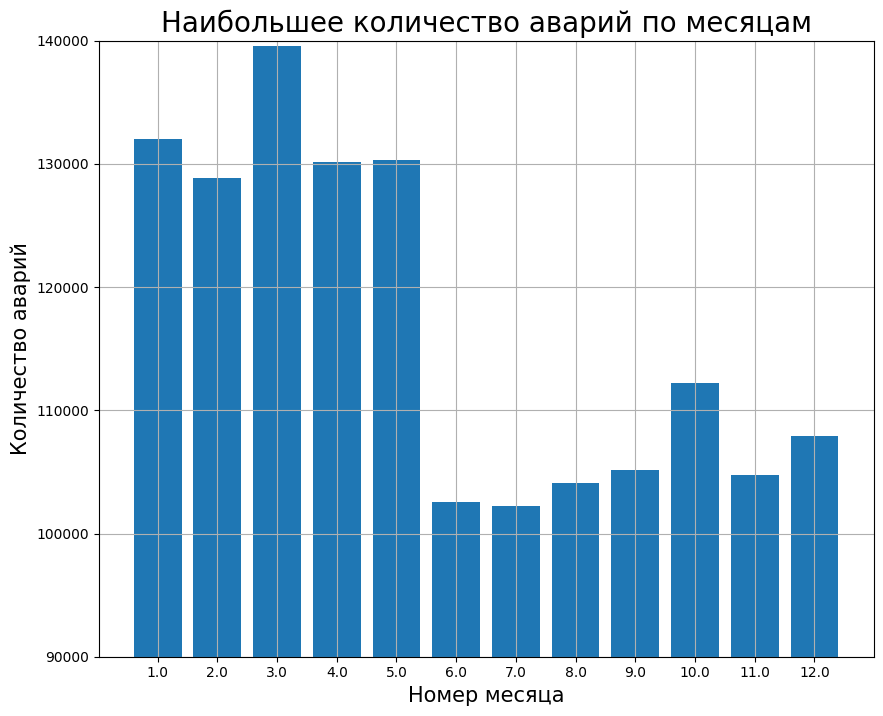

In [162]:
plt.bar(stat_df1.month, stat_df1.count_collisions, tick_label=[f"{i}" for i in stat_df1.month])
plt.grid(True)
plt.xlabel("Номер месяца", fontsize=15)
plt.ylabel("Количество аварий", fontsize=15)
plt.title("Наибольшее количество аварий по месяцам", fontsize=20)
plt.ylim (90000, 140000)

#### Вывод:
*Наибольшее количество аварий произошло в первые пять месяцев года, за весь период наблюдений происходило в марте - 139581 шт, меньше в январе - 132044 шт, на третьем месте май - 130316 шт.*

### 2. Задачи для коллег:
- В какое время суток чаще происходят аварии (найти среднее за каждый день)?
- Влияет ли погода на количество ДТП?
- Связано ли время суток и фактор аварии?
- При каком освещении чаще случаются ДТП?
- Назовите три самые частые категории нарушения.
- Влияет ли на тип аварии дополнительный участник ДТП?
- Машины какого возраста чаще становятся виновниками ДТП?
- Проведите анализ связи серьёзности нарушения и погоды.
- Какова доля происшествий по вине животных?
- Какова доля ДТП по вине пьяного водителя?

#### Порядок решения задачи: Машины какого возраста чаще становятся виновниками ДТП?
1. Объединить таблицы vehicles и parties.
3. Выбрать те автомобили, где он виновник.
4. Найти количество ТС каждого возраста.
5. Отразить на столбчатой диаграмме.
6. Сделать вывод.

In [163]:
query_col_stat2_1 = '''
SELECT vehicle_age,
       COUNT(*) AS count_vehicles
FROM vehicles AS v
INNER JOIN parties AS p ON v.case_id = p.case_id AND v.party_number = p.party_number
WHERE at_fault = 1 AND vehicle_age IS NOT NULL AND vehicle_age != 161
GROUP BY vehicle_age
ORDER BY count_vehicles DESC
'''
stat_df2_1 = pd.read_sql_query(query_col_stat2_1,engine)
stat_df2_1

,vehicle_age,count_vehicles
0,3,97354
1,2,58322
2,4,56428
3,5,40965
4,6,30641
5,7,30083
6,8,27349
7,9,20859
8,1,18349
9,0,18057


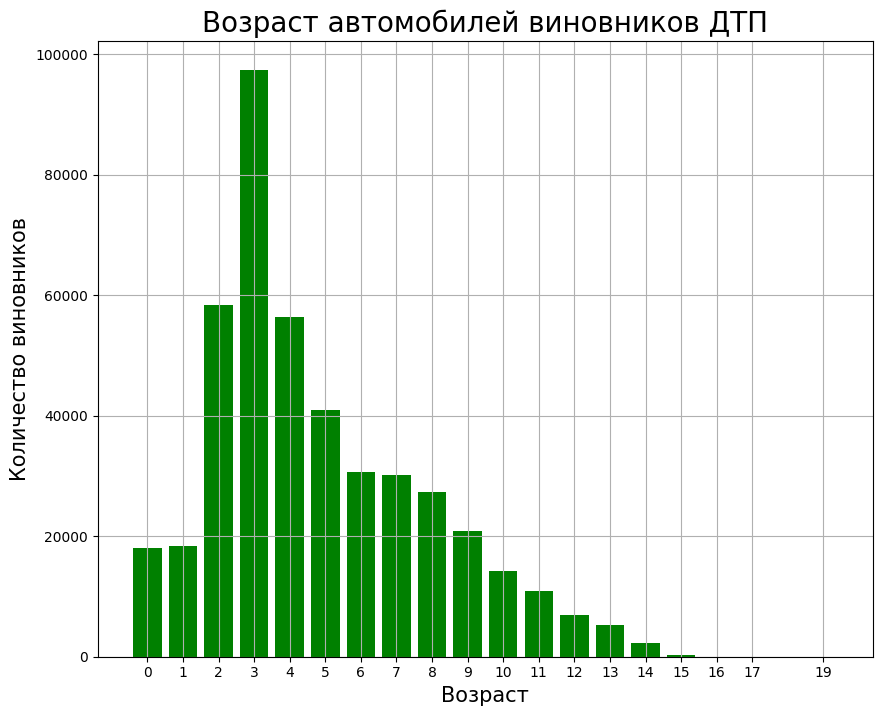

In [164]:
plt.bar(stat_df2_1.vehicle_age, stat_df2_1.count_vehicles, tick_label=[f"{i}" for i in stat_df2_1.vehicle_age], color = 'green')
plt.grid(True)
plt.xlabel("Возраст", fontsize=15)
plt.ylabel("Количество виновников", fontsize=15)
plt.title("Возраст автомобилей виновников ДТП", fontsize=20);
#plt.ylim (90000, 140000)

##### Вывод:
*В авариях виновниками в основном становятся автомобили возраста 2-4 года, в большинстве своем 3 года - 97354 виновника.*

#### Порядок решения задачи: Какова доля ДТП по вине животного?
1. Объединить таблицы collisions и parties.
3. Выбрать те происшествия, где участник только один, допучастник - животное, водитель - невиновен.
3. Высчитать количество происшествий.
4. Рассчитать долю таких происшествий от всего количества происшествий.
6. Сделать вывод.

In [165]:
query_col_stat2_2 = '''
SELECT COUNT(*)
FROM collisions AS с
INNER JOIN parties AS p ON с.case_id = p.case_id
WHERE at_fault = 0 AND party_count = 1 AND motor_vehicle_involved_with = 'animal'
'''
stat_df2_2 = pd.read_sql_query(query_col_stat2_2,engine)
stat_df2_2

,count
0,5375


In [166]:
query_col_stat2_4= '''
SELECT COUNT(DISTINCT (case_id))
FROM collisions
'''
stat_df2_4 = pd.read_sql_query(query_col_stat2_4,engine)
stat_df2_4

,count
0,1400000


In [167]:
round(stat_df2_2.loc[0,'count']*100/stat_df2_4.loc[0, 'count'],2)

np.float64(0.38)

##### Вывод:
Доля происшествий по вине животного 0.38% от всего количества происшествий.

## Создайте модель для оценки водительского риска

### 1. Подготовка набора данных на основе первичного предположения заказчика.

In [168]:
query_assumption_3 = '''
SELECT p.id,
            p.case_id,
            p.party_number,
            p.party_type,
            p.at_fault,
            collision_damage,
            collision_date,
            intersection,
            weather_1,
            road_surface,
            lighting,
            distance,
            pcf_violation_category,
            motor_vehicle_involved_with,
            road_condition_1,
            party_sobriety,
            cellphone_in_use,
            insurance_premium

FROM parties AS p
INNER JOIN collisions AS c ON p.case_id = c.case_id
WHERE DATE_TRUNC('day', c.collision_date) >= '2012-01-01' AND DATE_TRUNC('day', c.collision_date) <= '2012-12-31'
AND collision_damage != 'scratch' AND ((at_fault=1 AND party_type = 'car') OR (at_fault = 0))
'''
stat_df_assumption_3 = pd.read_sql_query(query_assumption_3,engine)
stat_df_assumption_3

,id,case_id,party_number,party_type,at_fault,collision_damage,collision_date,intersection,weather_1,road_surface,lighting,distance,pcf_violation_category,motor_vehicle_involved_with,road_condition_1,party_sobriety,cellphone_in_use,insurance_premium
0,2417532,5460843,2,other,0,small damage,2012-01-12,0.0,clear,dry,dark with street lights,0.0,unsafe starting or backing,other motor vehicle,normal,not applicable,0.0,NaN
1,2395177,5448728,2,road bumper,0,middle damage,2012-01-12,0.0,clear,dry,dark with street lights,385.0,dui,parked motor vehicle,normal,not applicable,0.0,NaN
2,2395178,5448728,3,road bumper,0,middle damage,2012-01-12,0.0,clear,dry,dark with street lights,385.0,dui,parked motor vehicle,normal,not applicable,0.0,NaN
3,2395179,5448728,4,road bumper,0,middle damage,2012-01-12,0.0,clear,dry,dark with street lights,385.0,dui,parked motor vehicle,normal,not applicable,0.0,NaN
4,2395294,5448790,2,road bumper,0,small damage,2012-01-16,0.0,cloudy,dry,daylight,100.0,unknown,parked motor vehicle,normal,not applicable,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217369,2409729,5456610,1,car,1,small damage,2012-01-15,0.0,clear,dry,dark with no street lights,100.0,improper turning,non-collision,normal,had not been drinking,0.0,20.0
217370,2409766,5456632,1,car,1,small damage,2012-01-09,1.0,clear,dry,daylight,0.0,following too closely,other motor vehicle,normal,had not been drinking,0.0,57.0
217371,2409767,5456632,2,car,0,small damage,2012-01-09,1.0,clear,dry,daylight,0.0,following too closely,other motor vehicle,normal,had not been drinking,0.0,51.0
217372,2409768,5456633,1,car,1,middle damage,2012-01-01,1.0,clear,dry,dark with street lights,0.0,dui,other motor vehicle,normal,"had been drinking, under influence",NaN,24.0


Соединим таблицу stat_df_assumption_3 с vehicles_df по case_id и номеру участника (party_number).

In [169]:
data = stat_df_assumption_3.merge(vehicles_df,
                                  how='inner', on = ['case_id', 'party_number'], suffixes=('_parties', '_vehicles'))
data

,id_parties,case_id,party_number,party_type,at_fault,collision_damage,collision_date,intersection,weather_1,road_surface,...,pcf_violation_category,motor_vehicle_involved_with,road_condition_1,party_sobriety,cellphone_in_use,insurance_premium,id_vehicles,vehicle_type,vehicle_transmission,vehicle_age
0,2397252,5449837,2,building,0,middle damage,2012-01-01,0.0,clear,dry,...,automobile right of way,bicycle,normal,had not been drinking,0.0,50.0,1321258,minivan,manual,8.0
1,2425379,5465022,3,road signs,0,middle damage,2012-01-10,1.0,cloudy,dry,...,automobile right of way,other object,normal,had not been drinking,0.0,69.0,1336534,hatchback,manual,11.0
2,2428329,5466590,2,building,0,middle damage,2012-01-08,0.0,clear,dry,...,automobile right of way,non-collision,normal,had not been drinking,0.0,64.0,1338190,minivan,manual,10.0
3,2428568,5466717,2,road signs,0,middle damage,2012-01-06,0.0,clear,dry,...,pedestrian right of way,other object,normal,had not been drinking,0.0,14.0,1338316,hatchback,manual,2.0
4,2428787,5466833,2,building,0,middle damage,2012-01-02,1.0,clear,dry,...,None,bicycle,normal,impairment unknown,0.0,58.0,1338427,minivan,manual,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60066,2409472,5456467,2,car,0,middle damage,2012-01-13,1.0,clear,dry,...,improper turning,other motor vehicle,normal,had not been drinking,0.0,33.0,1328102,sedan,auto,2.0
60067,2409473,5456467,3,car,0,middle damage,2012-01-13,1.0,clear,dry,...,improper turning,other motor vehicle,normal,had not been drinking,0.0,53.0,1328103,sedan,auto,8.0
60068,2409474,5456468,1,car,1,middle damage,2012-01-20,1.0,clear,dry,...,improper turning,other motor vehicle,normal,had not been drinking,0.0,62.0,1328105,coupe,auto,9.0
60069,2409475,5456468,2,car,0,middle damage,2012-01-20,1.0,clear,dry,...,improper turning,other motor vehicle,normal,had not been drinking,0.0,62.0,1328106,sedan,auto,9.0


Оставляем только нужные столбцы.

### 2. Первичный отбор факторов, необходимых для модели (исправление или аргументация предыдущего вывода):


Оставляем только нужные столбцы.

In [170]:
data.columns

Index(['id_parties', 'case_id', 'party_number', 'party_type', 'at_fault',
       'collision_damage', 'collision_date', 'intersection', 'weather_1',
       'road_surface', 'lighting', 'distance', 'pcf_violation_category',
       'motor_vehicle_involved_with', 'road_condition_1', 'party_sobriety',
       'cellphone_in_use', 'insurance_premium', 'id_vehicles', 'vehicle_type',
       'vehicle_transmission', 'vehicle_age'],
      dtype='object')

In [171]:
important_col = ['at_fault',
                 'intersection', #В рекомендованном водителю маршруте количество перекрестков будет отрегулировано в соответствии с рисками.
                 'weather_1',#Известна и прогнозируема на время поездки.
                 'lighting', #Может быть собрана статистика освещения до поездки по рекомендуемому маршруту.
                 'distance', #на главной дороге больше машин и вероятности ДТП. Рекомендованный маршрут может учесть и этот фактор.

                 'road_condition_1', #Может быть собрана статистика состояния дорог до поездки по рекомендуемому маршруту.

                 'cellphone_in_use',#отвлечение на разговор даже по громкой связи отвлекает от дороги. Зависит от автомобиля.
                 'vehicle_transmission', #может влиять, т.к. с ручной коробке передач не все могут справиться в опасной ситуации. Зависит от автомобиля
                 'vehicle_age', #как показало исследование, влияет, к тому же заказчик требует учесть.
                 'vehicle_type', #тип кузова, известен до поездки, возможно влияет из-за степени маневренности
                 'road_surface'# состояние дороги может известно по статистическим данным наряду с road_condition_1.
                 ]

data_important = data[important_col]

In [172]:
sh = data_important.shape[0]
data_important = data_important.drop_duplicates()
print('Размер нового датафрэйма -',data_important.shape[0])
print('Удалено строк -', sh - data_important.shape[0])
print ('Количество дубликатов в новой таблице data_important -', data_important.duplicated().sum())

Размер нового датафрэйма - 34683
Удалено строк - 25388
Количество дубликатов в новой таблице data_important - 0


In [173]:
data_important.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34683 entries, 0 to 60064
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   at_fault              34683 non-null  int64  
 1   intersection          34495 non-null  float64
 2   weather_1             34499 non-null  object 
 3   lighting              34507 non-null  object 
 4   distance              34683 non-null  float64
 5   road_condition_1      34406 non-null  object 
 6   cellphone_in_use      30550 non-null  float64
 7   vehicle_transmission  33879 non-null  object 
 8   vehicle_age           33567 non-null  float64
 9   vehicle_type          34683 non-null  object 
 10  road_surface          34300 non-null  object 
dtypes: float64(4), int64(1), object(6)
memory usage: 3.2+ MB


In [174]:
data_important['weather_1'] = data_important['weather_1'].fillna('other')

data_important['road_condition_1'] = data_important['road_condition_1'].fillna('other')
data_important['vehicle_type'] = data_important['vehicle_type'].fillna('other')


In [175]:
#составим список столбцов с малочисленными пропусками (менее 1,2%)
sh = data_important.shape[0]
col = []
for i in data_important.columns:
    if (data_important[i].isna().sum()*100/sh > 0) and (data_important[i].isna().sum()*100/sh < 1.2):
        col.append(i)
print(col)

['intersection', 'lighting', 'road_surface']


In [176]:
data_important = data_important.dropna(subset=col) #удалим пропуски
print('Количество строк data_important -',data_important.shape[0])
print(f'Датафрэйм уменьшился на {round((sh-data_important.shape[0])*100/sh,0)} процента')

Количество строк data_important - 34010
Датафрэйм уменьшился на 2.0 процента


In [177]:
data_important['cellphone_in_use'] = data_important['cellphone_in_use'].fillna(2) #заполним пропуски в столбце "заглушкой"

/tmp/ipython-input-177-3575881511.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_important['cellphone_in_use'] = data_important['cellphone_in_use'].fillna(2) #заполним пропуски в столбце "заглушкой"


In [178]:
data_important['intersection'] = data_important['intersection'].astype(int)
data_important['cellphone_in_use'] = data_important['cellphone_in_use'].astype(int)

data_important['vehicle_transmission'] = data_important['vehicle_transmission'].fillna('other')

/tmp/ipython-input-178-2714279629.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_important['intersection'] = data_important['intersection'].astype(int)
/tmp/ipython-input-178-2714279629.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_important['cellphone_in_use'] = data_important['cellphone_in_use'].astype(int)
/tmp/ipython-input-178-2714279629.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

In [179]:
data_important.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34010 entries, 0 to 60064
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   at_fault              34010 non-null  int64  
 1   intersection          34010 non-null  int64  
 2   weather_1             34010 non-null  object 
 3   lighting              34010 non-null  object 
 4   distance              34010 non-null  float64
 5   road_condition_1      34010 non-null  object 
 6   cellphone_in_use      34010 non-null  int64  
 7   vehicle_transmission  34010 non-null  object 
 8   vehicle_age           32924 non-null  float64
 9   vehicle_type          34010 non-null  object 
 10  road_surface          34010 non-null  object 
dtypes: float64(2), int64(3), object(6)
memory usage: 3.1+ MB


Пропуски в столбце vehicle_age заменим на медианное значение после разделения данных на выборки.

### Промежуточный вывод:
*Подготовлены данные на основе первичного предположения заказчика: тип виновника — только машина (car), ДТП привело к любым значимым повреждениям автомобиля любого из участников — все, кроме типа SCRATCH (царапина), данные только за 2012 год.*

*Проведен первичный отбор факторов, необходимых для модели. Приняты следующие признаки:*
- Перекресток/неперекресток (intersection)
- Погода (weather_1)
- Расстояние от главной дороги (distance)
- Категория нарушения (pcf_violation_category)
- Дорожное состояние (road_condition_1)
- Трезвость участника (party_sobriety)
- Наличие телефона в автомобиле (cellphone_in_use)
- Возраст автомобиля (vehicle_age)
- тип КПП (vehicle_transmission).

*Удалены или заполнены пропуски, удалены дубликаты.*

*По итогу получаем датафрэйм в котором 42062 строк и 11 столбцов.*

*Потребуется также заполнить vehicle_age медианными значениями после разделения данных на выборки и удалить выбросы, если они будут в тернировочной выборке.*

### 3. Проведем статистическое исследование отобранных факторов.

In [180]:
def categ (name_column, quantity, name,df=data_important): #функция для анализа категориальных столбцов
    #plt.figure(figsize=(28,28))
    v1 = df[name_column].value_counts().head(quantity)
    print('Количество значений каждой категории:')
    print(v1)
    print()
    print('Всего значений -', df[name_column].value_counts().shape[0])

    lb1 = v1.index

    fig, ax = plt.subplots();

    ax.pie(v1, labels=lb1, autopct='%1.1f%%')

    plt.title(name, fontsize=20)

    return

In [181]:
def numbers(name_column, df): #функция для анализа числовых столбцов
    plt.figure(figsize=(16, 12))

    plt.subplot(2,2,1)
    df[name_column].hist(bins=20)
    plt.ylabel("Частота")
    plt.xlabel(name_column)
    plt.title('Распределение данных')


    try:
        plt.subplot(2,2,3)
        df.boxplot(name_column, color = 'green')
        plt.ylabel(x_title)
        plt.title('Ящик с усами')
        plt.show()

    except:
        print('Ящик с усами не построить')


    print('Статистика')
    print(df[name_column].describe())

    return;

In [182]:
def categorical_features(df, attribute, title, hue='at_fault', top_n=10): #функция для анализа зависимости от значения целевой переменной

    counts = df[attribute].value_counts(ascending=False)
    if len(counts) > top_n:
        counts = counts[:top_n]

    if hue not in df.columns:
        hue = None

    if hue:
        fig, axes = plt.subplots(2, 1, figsize=(12, 10), gridspec_kw={'height_ratios': [2, 3]})
        show_percentage = True
    else:
        fig, axes = plt.subplots(1, 1, figsize=(12, 6))
        axes = [axes]
        show_percentage = False

    sns.countplot(
        x=attribute, data=df[df[attribute].isin(counts.index)], palette='afmhot_r', hue=hue,
        order=counts.index, ax=axes[0]
    )
    axes[0].set_title(title, fontsize=14, fontweight='bold')
    axes[0].set_xlabel(attribute, fontsize=10)
    axes[0].set_ylabel('Частота', fontsize=10)
    axes[0].tick_params(axis='x', rotation=90)
    if hue:
        axes[0].legend(title=hue, loc='upper right')

    if show_percentage:
        percentage = df[df[attribute].isin(counts.index)].groupby([attribute, hue]).size().unstack().fillna(0)
        percentage = percentage.div(percentage.sum(axis=1), axis=0)
        percentage = percentage.loc[counts.index]

        percentage.plot(kind='bar', stacked=True, colormap='Set2', ax=axes[1])
        axes[1].set_ylabel('Доля', fontsize=12)
        axes[1].set_xlabel(attribute, fontsize=12)
        axes[1].tick_params(axis='x', rotation=90)
        axes[1].legend(title=hue, bbox_to_anchor=(1, 1), loc='upper left')
        axes[1].set_title(f"{title} (долевое распределение)", fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.show()


In [183]:
data_important.columns

Index(['at_fault', 'intersection', 'weather_1', 'lighting', 'distance',
       'road_condition_1', 'cellphone_in_use', 'vehicle_transmission',
       'vehicle_age', 'vehicle_type', 'road_surface'],
      dtype='object')

#### at_fault

Количество значений каждой категории:
at_fault
1    17059
0    16951
Name: count, dtype: int64

Всего значений - 2


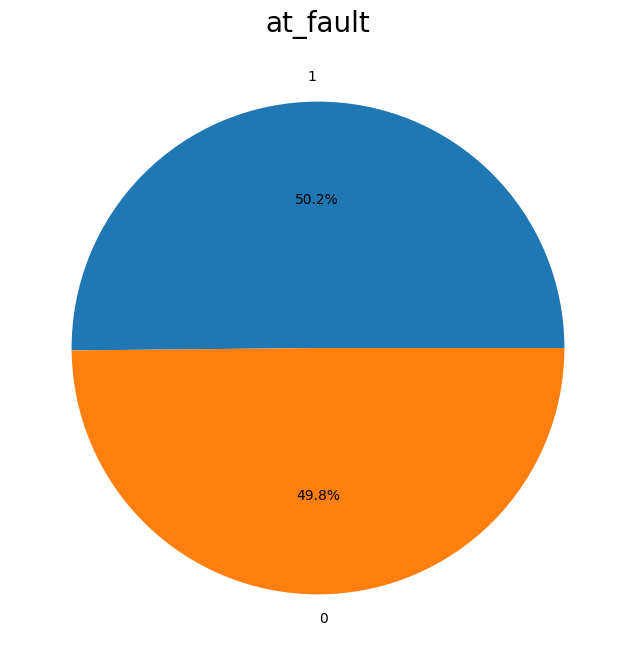

In [184]:
categ('at_fault',2,'at_fault')

*Целевая переменная досточно сбалансирована*.

#### Категориальные признаки.

##### intersection

Количество значений каждой категории:
intersection
0    31555
1     2455
Name: count, dtype: int64

Всего значений - 2


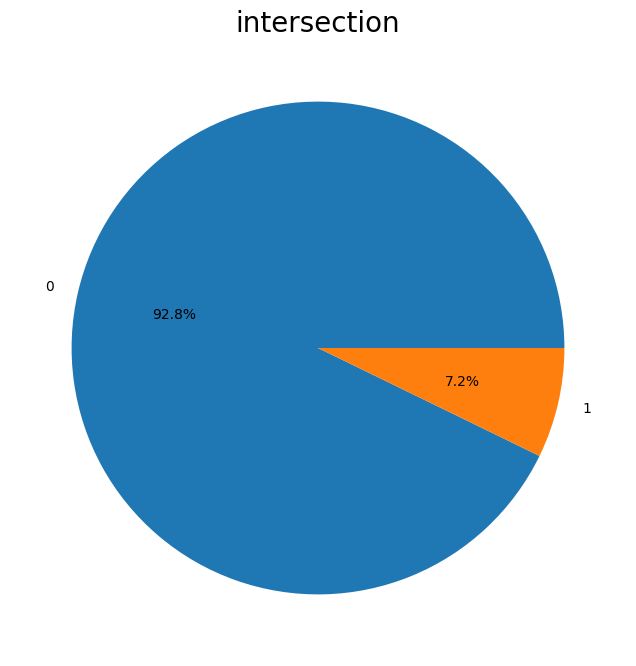

In [185]:
categ('intersection',5,'intersection')

Столбец имеет значения, требующие расшифровки. Исправим значения в столбце так, чтобы расшифровка не потребовалась: 0 - not intersection, 1 - intersection.

In [186]:
data_important['intersection_new'] = data_important['intersection'].apply(
    lambda x: 'yes' if x == 1 else 'no')
data_important = data_important.drop('intersection', axis=1)
data_important['intersection_new'].value_counts()

,count
intersection_new,
no,31555
yes,2455




*Анализ мест происшествия говорит, что перекрестков встречается мало, в нашем датасете ~~12,5%~~ 11,2%. Метки о факте перекрестка за менили на yes/no.*

Рассматривать завимисимость этого признака от значения целевой переменной не имеет смысла, т.к. в любой аварии на перекрестке или не на перекресте обязательно одна строна будет виновна и чаще 1 сторона невиновна, т.е. 50/50.

##### weather_1

Количество значений каждой категории:
weather_1
clear      24689
cloudy      6852
raining     1961
fog          192
snowing      159
other        144
wind          13
Name: count, dtype: int64

Всего значений - 7


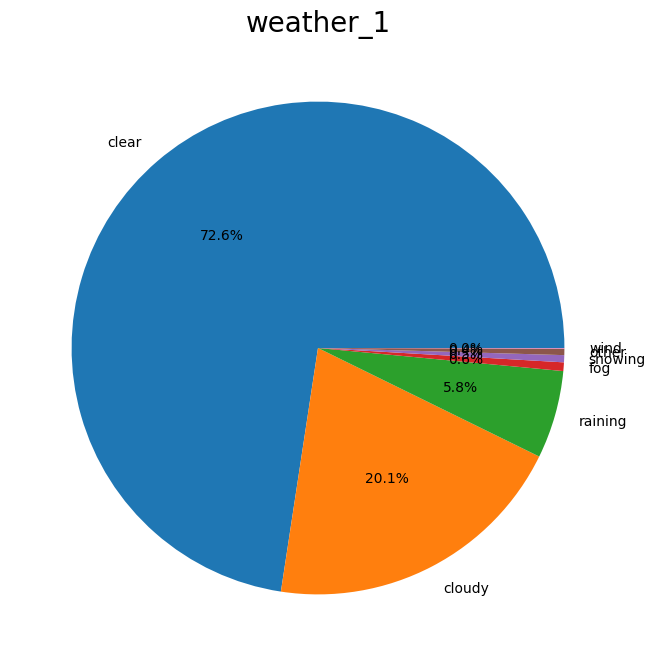

In [187]:
categ('weather_1',10,'weather_1')


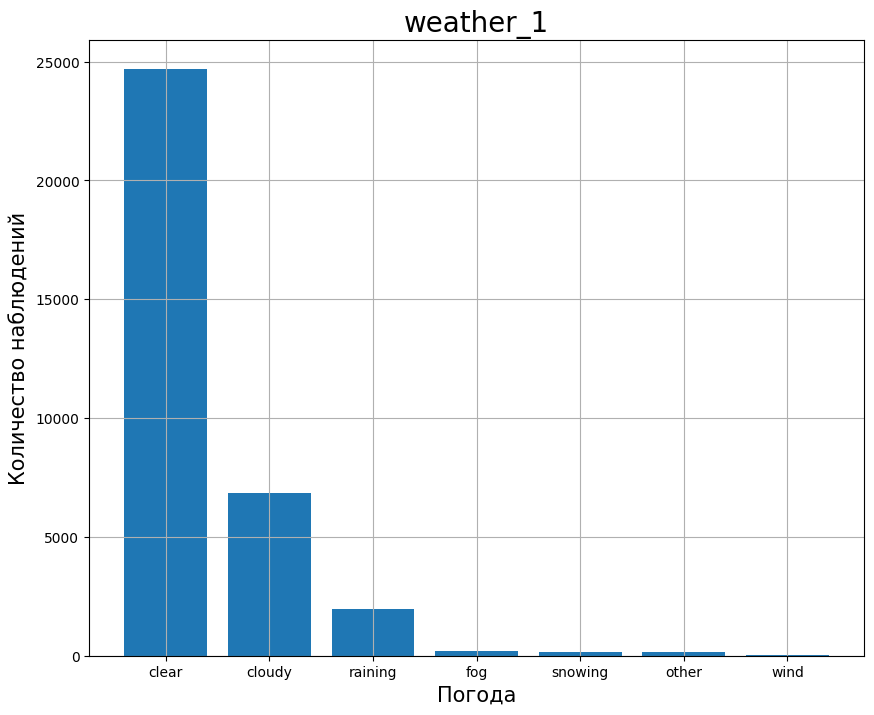

In [188]:
v1 = data_important.weather_1.value_counts()
plt.bar(v1.index, v1)
plt.grid(True)
plt.xlabel("Погода", fontsize=15)
plt.ylabel("Количество наблюдений", fontsize=15)
plt.title("weather_1", fontsize=20);


*Удивительно, но в основном ДТП происходили при ясной погоде - 76,7% случаев, меньше в облачную и дождливую погоду. Туман, снегопад, ветер и др. очень мало случаев*.

##### road_surface

Количество значений каждой категории:
road_surface
dry         28927
wet          4674
snowy         365
slippery       44
Name: count, dtype: int64

Всего значений - 4


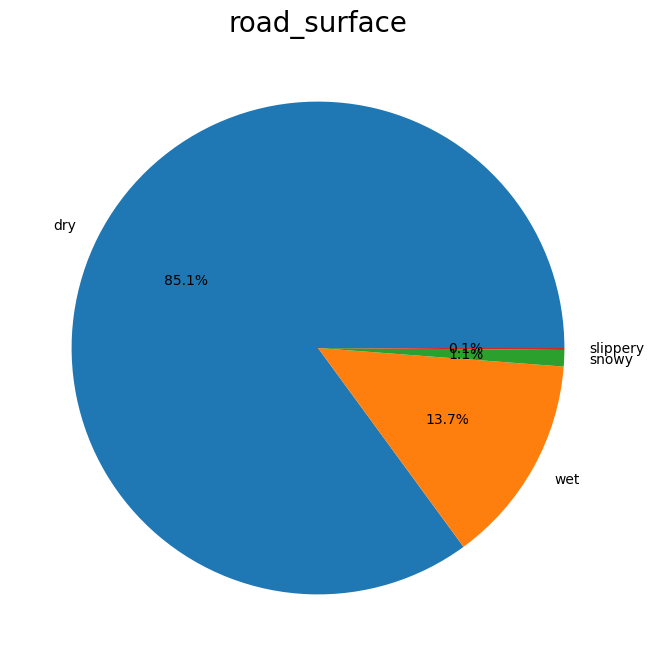

In [189]:
categ('road_surface',10,'road_surface')

*Удивительно также, но бОльшая часть ДТП (85,1%) произошло на сухой дороге, только 13,7% - на мокрой. На заснеженной или скользкой почти не было аварий - 1,2%*.

##### lighting

Количество значений каждой категории:
lighting
daylight                                   20749
dark with street lights                     7394
dark with no street lights                  4183
dusk or dawn                                1539
dark with street lights not functioning      145
Name: count, dtype: int64

Всего значений - 5


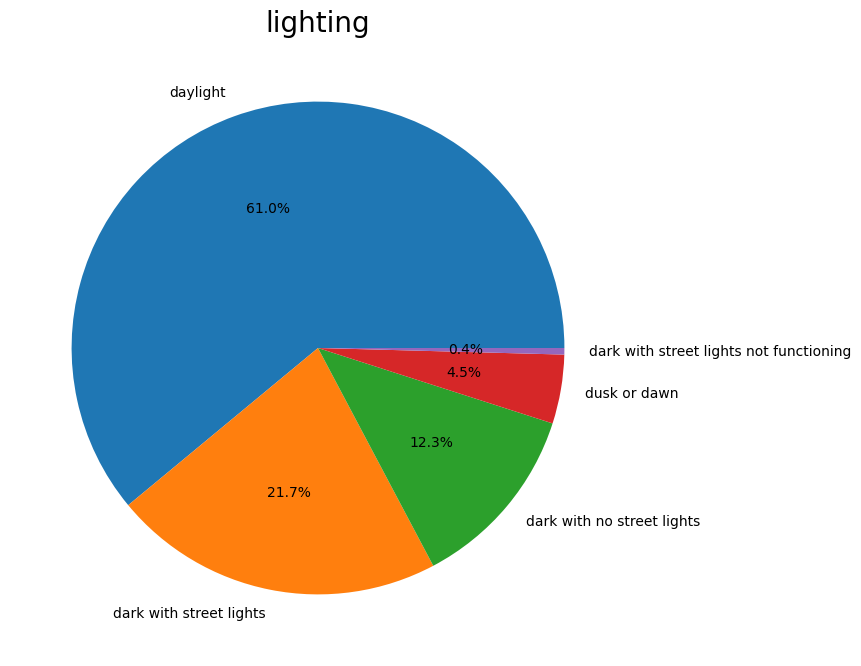

In [190]:
categ('lighting',10,'lighting')

*Основная часть аварий происходила при дневном освещении (62,8%), это связано с временем активности водителей. 21,6 % в темноте при освещении фонарей, только 15,7% - в темноте без освещения+с неработающими фонарями*

##### road_condition_1

Количество значений каждой категории:
road_condition_1
normal            31979
construction        955
other               435
obstruction         257
holes               145
loose material      134
reduced width        69
flooded              36
Name: count, dtype: int64

Всего значений - 8


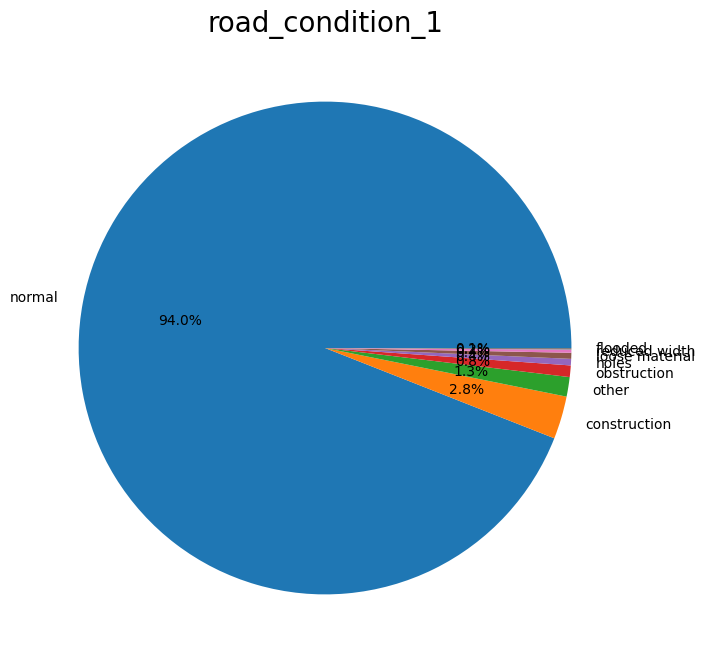

In [191]:
categ('road_condition_1',22,'road_condition_1')

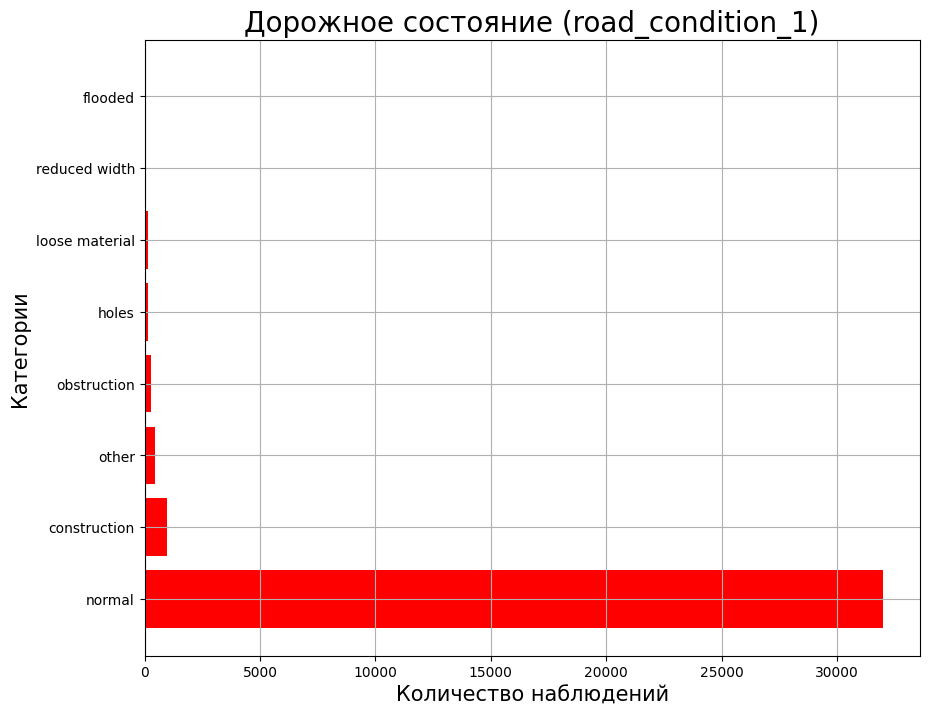

In [192]:
v1 = data_important.road_condition_1.value_counts()
plt.barh(v1.index, v1, color = 'red')
plt.grid(True)
plt.xlabel("Количество наблюдений", fontsize=15)
plt.ylabel("Категории", fontsize=15)
plt.title("Дорожное состояние (road_condition_1)", fontsize=20);

*В основном аварии совершались на нормальной дороге - 94,8%. Если не на нормальной, то в зоне строительства, другое(ненормальное состояние), препятствие.*

*От состояния участника ДТП зависела виновность или невиновность участника: в большинстве случаев пьяные были виновны: под влиянием или не по влиянием, трезвые чаще были невиновны.*

##### cellphone_in_use

Количество значений каждой категории:
cellphone_in_use
0    29018
2     3976
1     1016
Name: count, dtype: int64

Всего значений - 3


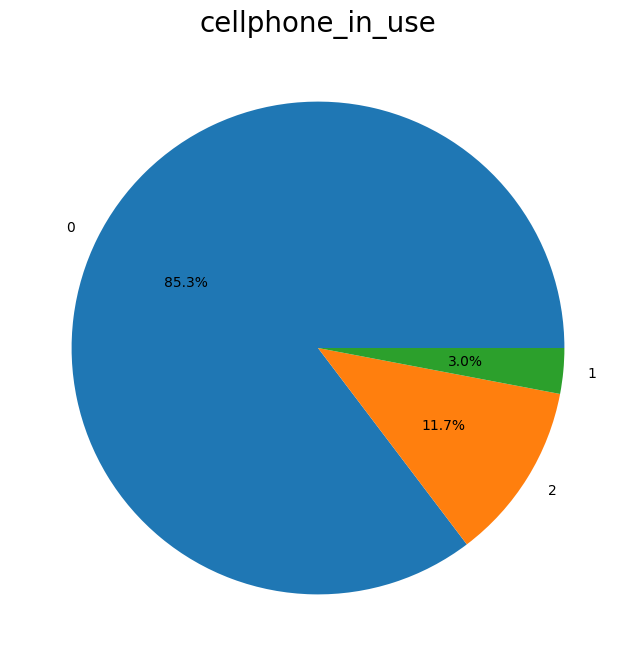

In [193]:
categ('cellphone_in_use',10,'cellphone_in_use')

Здесь также категории 0,1,2 заменим на строки соответственно: "not used", "was used", "unknown".

In [194]:
def cellphone(z):
    if z==1:
        return "was used"
    elif z ==2:
        return "unknown"
    else:
        return "not used"

data_important['cellphone_in_use_new'] = data_important['cellphone_in_use'].apply(cellphone)
data_important = data_important.drop('cellphone_in_use', axis=1)
data_important['cellphone_in_use_new'].value_counts()

,count
cellphone_in_use_new,
not used,29018
unknown,3976
was used,1016


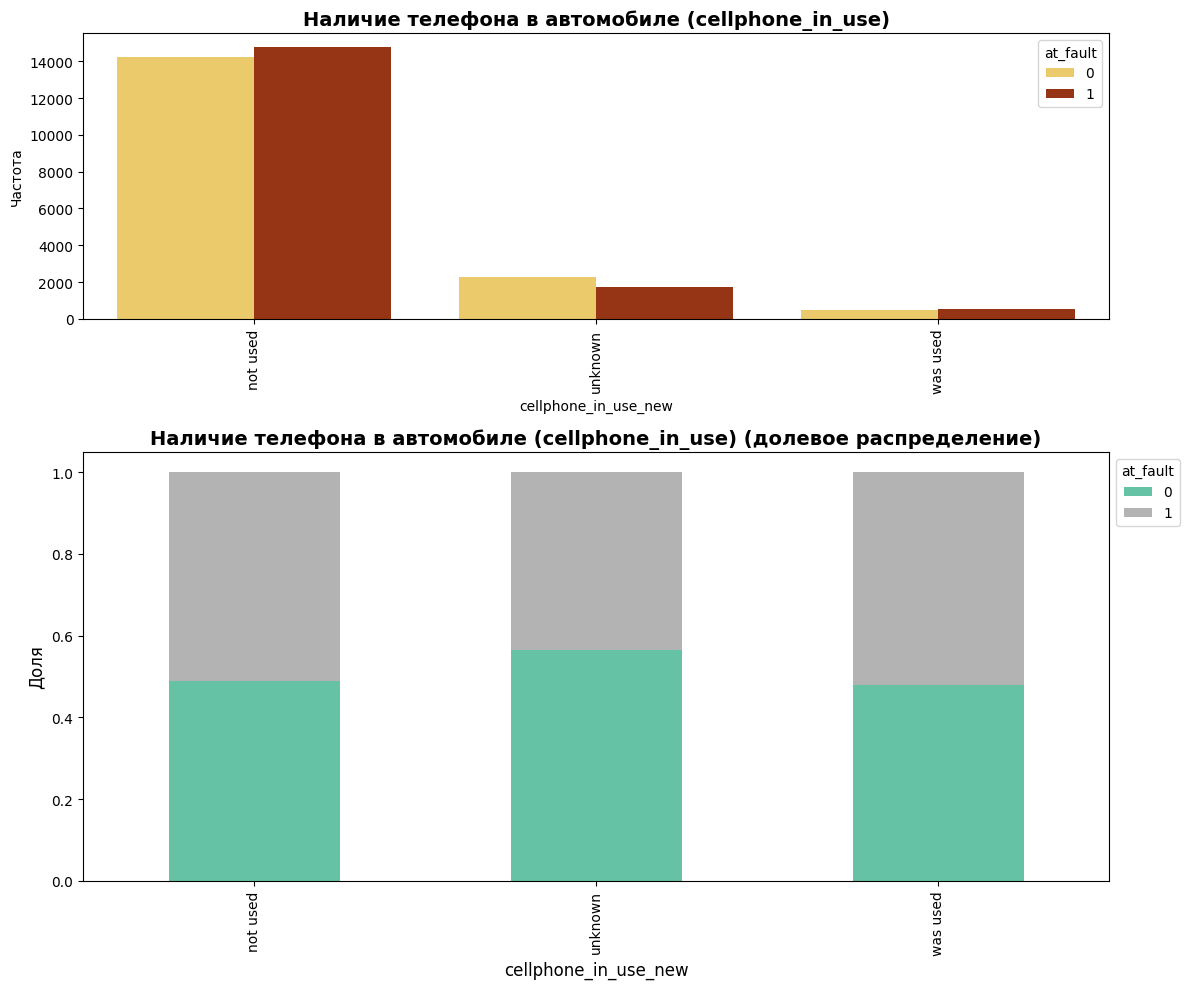

In [195]:
categorical_features(data_important,'cellphone_in_use_new','Наличие телефона в автомобиле (cellphone_in_use)')

*В большинстве случаев телефон не повлиял на аварию, потому что его не было в автомобиле у (86,2%). В 11,3% случаев телефон был в автомобиле*.

*Графики показывают, что наличие телефона в автомобиле почти не повлияло на виновность в аварии, т.к. половина с телефоном билы виновны, половина не виновны, то же без телефона.*

##### vehicle_transmission

Количество значений каждой категории:
vehicle_transmission
manual    18196
auto      15024
other       790
Name: count, dtype: int64

Всего значений - 3


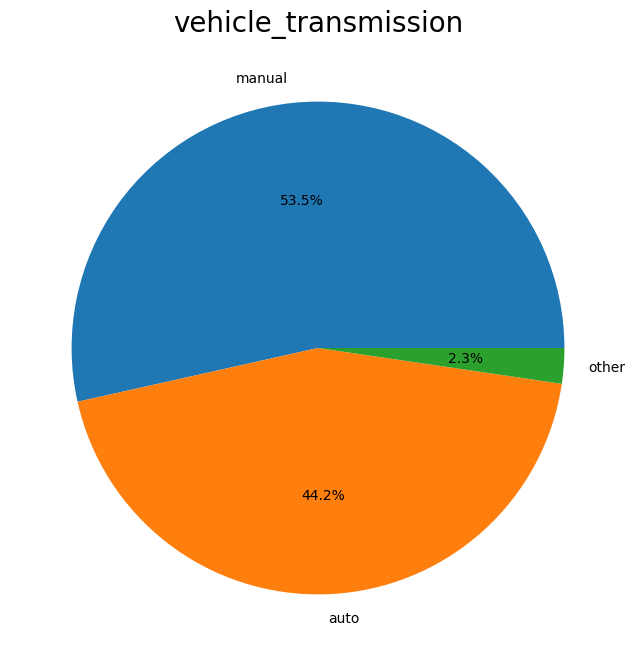

In [196]:
categ('vehicle_transmission',10,'vehicle_transmission')

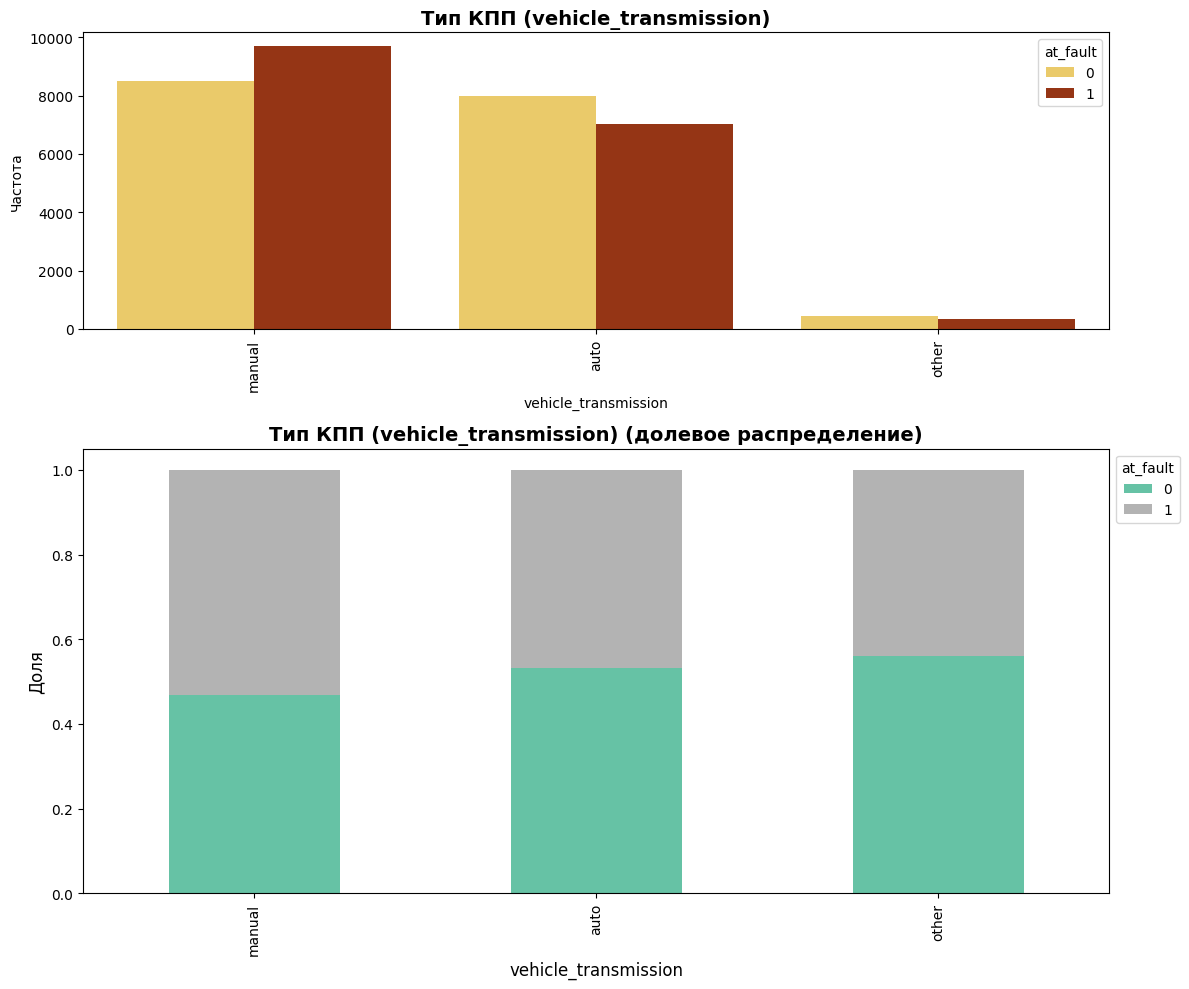

In [197]:
categorical_features(data_important,'vehicle_transmission','Тип КПП (vehicle_transmission)')

*Машин с механической коробкой передач больше (53,2%), чем с автоматической (44,7%) и виновников больше с ручной коробкой передач, чем с ручной*.

##### vehicle_type

Количество значений каждой категории:
vehicle_type
sedan        19971
coupe        11818
hatchback     1301
minivan        884
other           36
Name: count, dtype: int64

Всего значений - 5


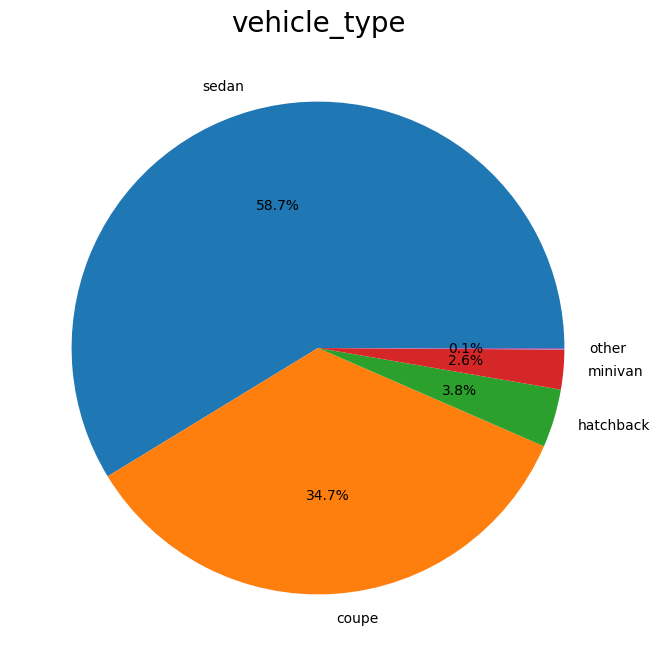

In [198]:
categ('vehicle_type',10,'vehicle_type')

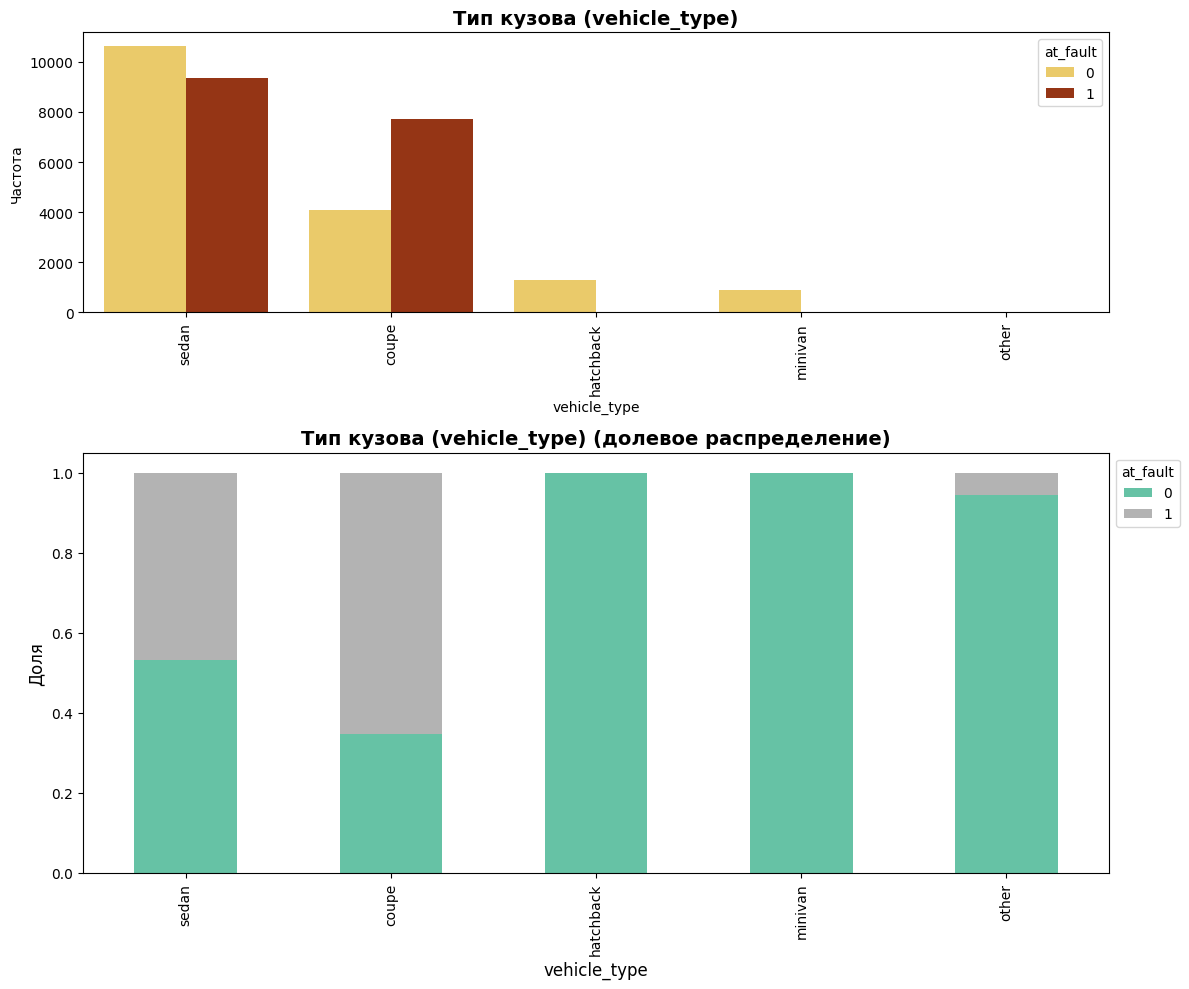

In [199]:
categorical_features(data_important,'vehicle_type','Тип кузова (vehicle_type)')

*Основная часть машин по виду кузова это седаны (58,7%) и купе (34,7%). Остальных меньше 6%. Соответственно и статистика виновных приходится на эти два типа. Седаны в одинаковой стпени как виноваты, так и невиноваты. А вот купэ бывают виновны чаще, чем невиновны. Хэчбэк и минивен всегда невиновны.*

#### Количественные признаки

##### vehicle_age

Ящик с усами не построить
Статистика
count    32924.000000
mean         5.208419
std          3.437342
min          0.000000
25%          3.000000
50%          5.000000
75%          7.000000
max        161.000000
Name: vehicle_age, dtype: float64


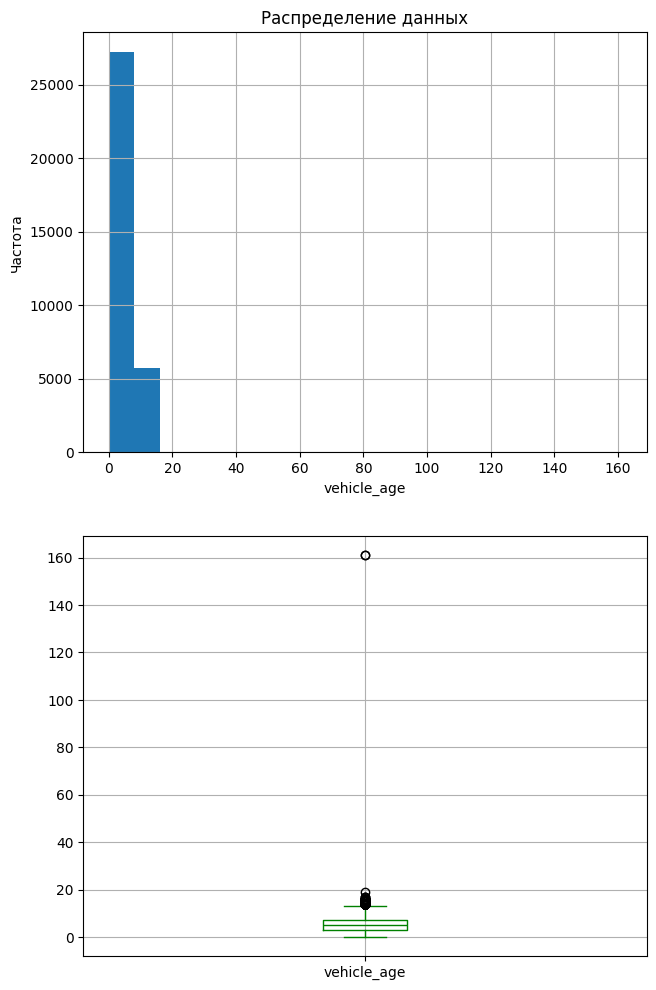

In [200]:
numbers('vehicle_age', data_important)

В среднем участники ДТП - это автомобили 4 лет. Но есть аномальное значение. Исследуем данные без него.

Ящик с усами не построить
Статистика
count    32922.000000
mean         5.198955
std          3.215812
min          0.000000
25%          3.000000
50%          5.000000
75%          7.000000
max         19.000000
Name: vehicle_age, dtype: float64


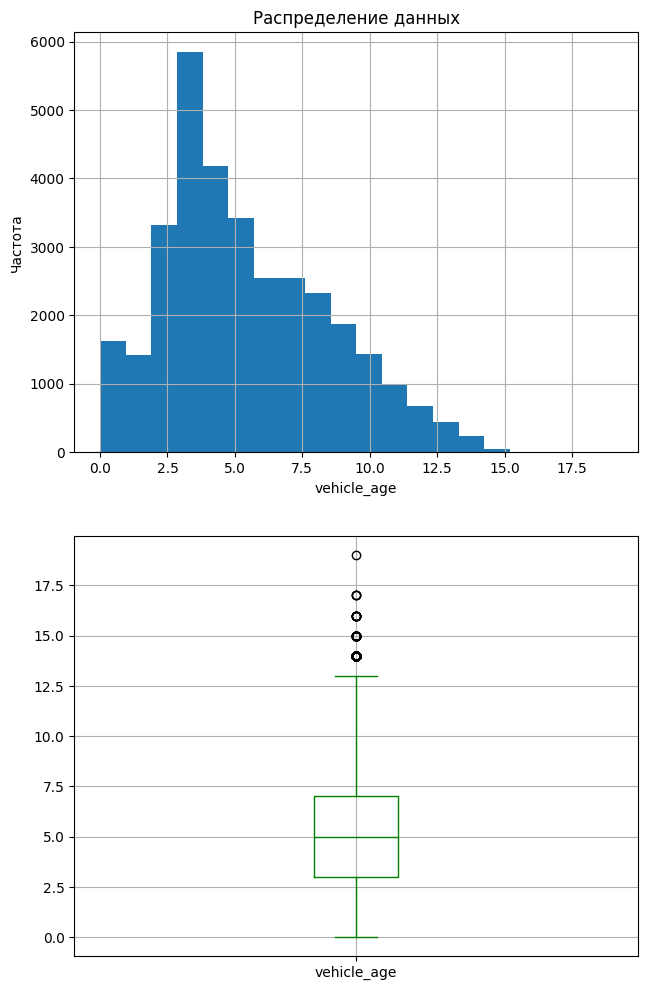

In [201]:
data_important_clear = data_important.query('vehicle_age < 161')
numbers('vehicle_age', data_important_clear)

In [202]:
data_important.query('vehicle_age >13')

,at_fault,weather_1,lighting,distance,road_condition_1,vehicle_transmission,vehicle_age,vehicle_type,road_surface,intersection_new,cellphone_in_use_new
196,0,clear,daylight,173.0,normal,auto,14.0,hatchback,dry,no,not used
330,0,clear,daylight,44.0,normal,auto,14.0,sedan,dry,no,unknown
566,1,cloudy,daylight,0.0,normal,manual,14.0,sedan,wet,yes,not used
1339,1,cloudy,daylight,500.0,normal,auto,14.0,sedan,wet,no,not used
1421,0,clear,daylight,0.0,normal,auto,16.0,sedan,dry,yes,not used
...,...,...,...,...,...,...,...,...,...,...,...
58794,1,other,dusk or dawn,50.0,normal,manual,14.0,sedan,dry,no,not used
59335,0,clear,dark with no street lights,683.0,normal,auto,14.0,sedan,dry,no,not used
59369,1,cloudy,daylight,5280.0,normal,auto,15.0,sedan,dry,no,not used
59493,0,clear,daylight,69.0,normal,auto,14.0,sedan,dry,no,not used


*В авариях в основном учавствуют автомобили 2-5 лет. Чаще всех 3 летнего возраста (более 7 тыс. авто). Та же статистика и по виновникам аварий.*

*Медиана - 4 года. Есть многи выбросов, точнее 314 строк, отличающихся от остальной массы автомобилей, поэтому их оставим*.

*От аномалии 161 год избавимся, если она попадет в тренировочную выборку*.

##### distance

Ящик с усами не построить
Статистика
count    3.401000e+04
mean     1.129705e+03
std      9.250576e+03
min      0.000000e+00
25%      4.800000e+01
50%      2.070000e+02
75%      7.647500e+02
max      1.584000e+06
Name: distance, dtype: float64


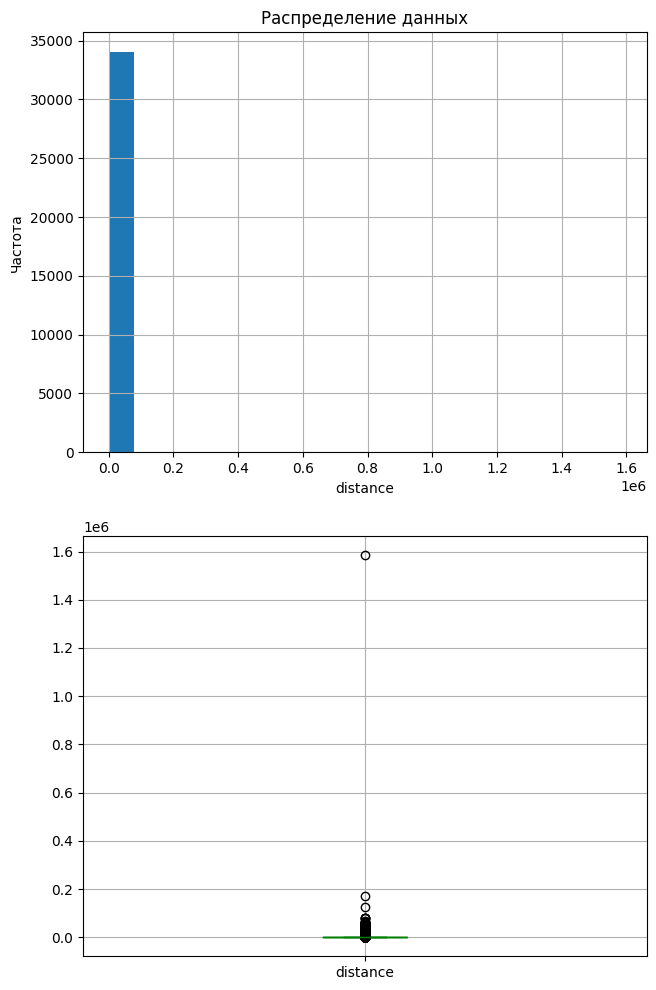

In [203]:
numbers('distance', data_important)

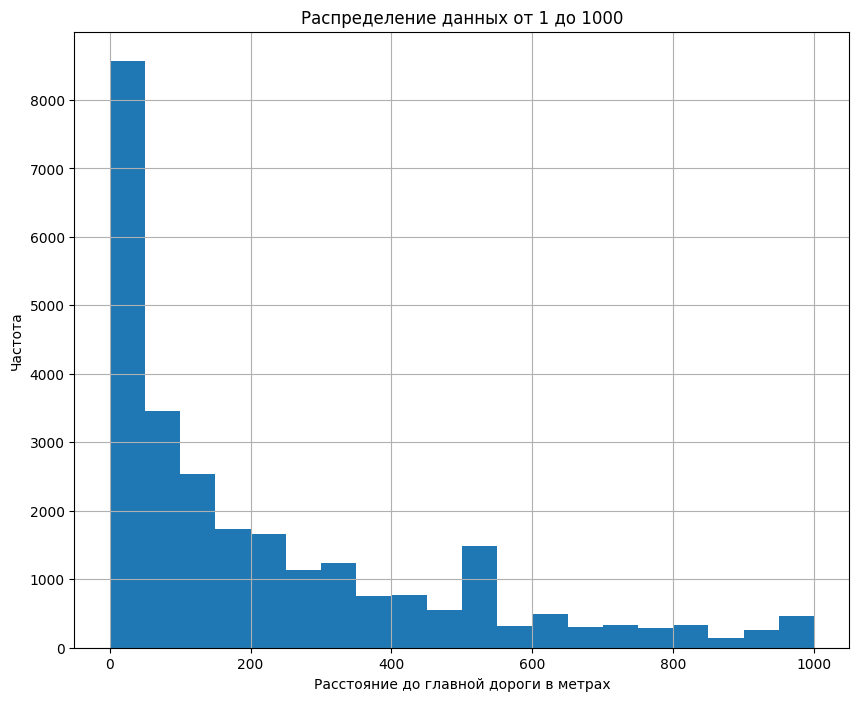

In [204]:
data_important['distance'].hist(bins=20, range=(0,1000))
plt.ylabel('Частота')
plt.xlabel("Расстояние до главной дороги в метрах")
plt.title('Распределение данных от 1 до 1000');

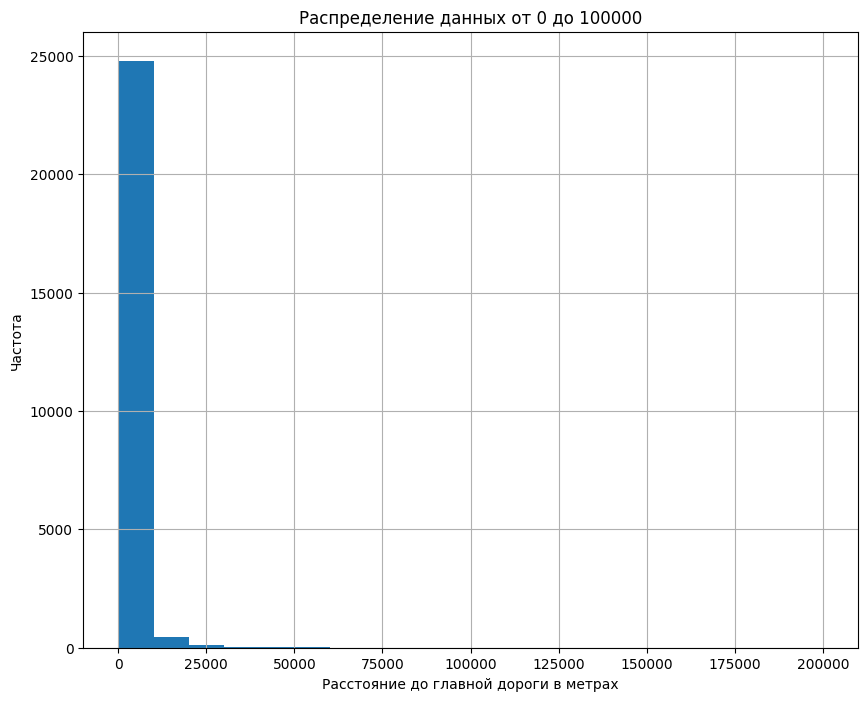

In [205]:
data_important['distance'].hist(bins=20, range=(50,200000))
plt.ylabel('Частота')
plt.xlabel("Расстояние до главной дороги в метрах")
plt.title('Распределение данных от 0 до 100000');

In [206]:
data_important.query('distance > 1500000')

,at_fault,weather_1,lighting,distance,road_condition_1,vehicle_transmission,vehicle_age,vehicle_type,road_surface,intersection_new,cellphone_in_use_new
24919,1,clear,daylight,1584000.0,normal,manual,3.0,sedan,dry,no,not used


In [207]:
data_important = data_important.query('distance < 200000')

In [208]:
data_important['distance'].describe()

,distance
count,34009.000000
mean,1083.162537
std,3449.682212
min,0.000000
25%,48.000000
50%,207.000000
75%,764.000000
max,171600.000000


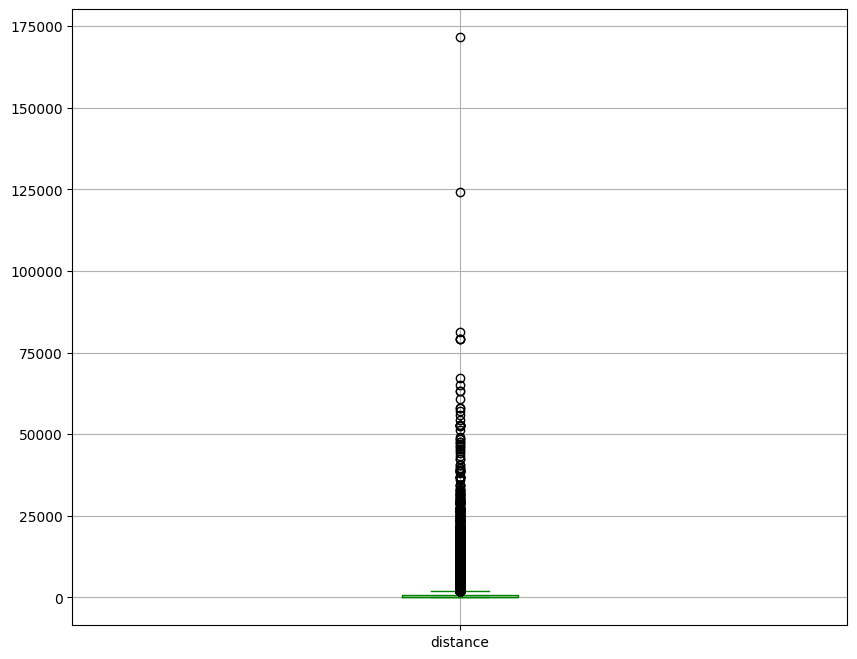

In [209]:
data_important.boxplot('distance', color = 'green');

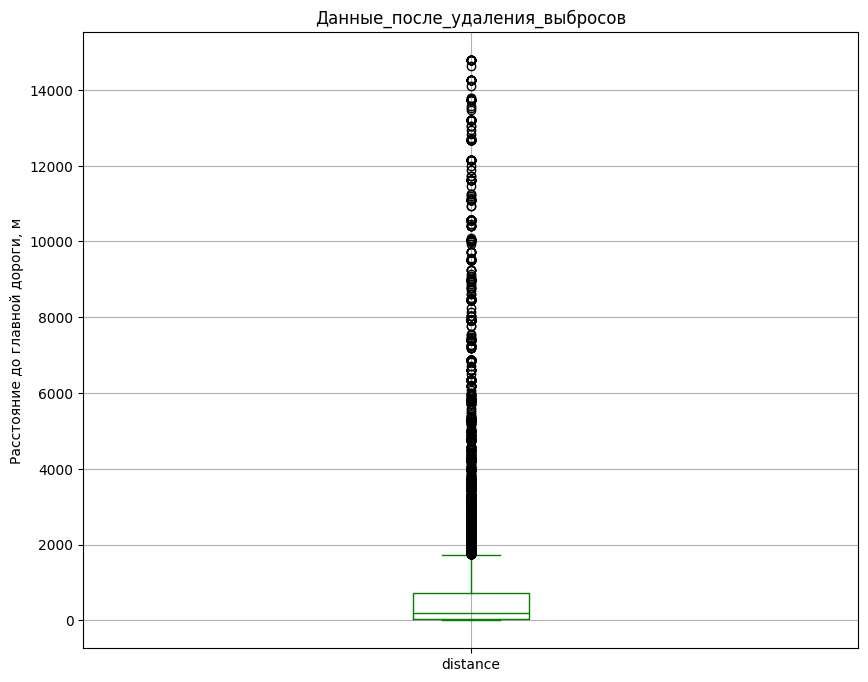

In [210]:
q99 = data_important['distance'].quantile(0.99)

data_important_clear = data_important[data_important['distance'] <= q99]

data_important_clear.boxplot('distance', color = 'green')
plt.ylabel('Расстояние до главной дороги, м')
plt.title('Данные_после_удаления_выбросов');

Если удалить 99-процентный квантиль, понятно, что выбросов нет, есть хвост из совершенно разных значений расстояния до главной дороги. Удалим лишь самое выбивающееся значение 1,584 тыс. км. Если оно попадет в тренировочную выборку.

*Больше 12 тыс. случаев на расстоянии 0-50 м от главной дороги. Более 28 тыс. на расстоянии 1 км. В среднем (медиана) - это 95 м. Но есть выбросы, один из них с расстоянием более 1,5 тыс км будет удалён, если попадет в тренировочную выборку.*

### 4. Взаимосвязь признаков.

In [211]:
data_important.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34009 entries, 0 to 60064
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   at_fault              34009 non-null  int64  
 1   weather_1             34009 non-null  object 
 2   lighting              34009 non-null  object 
 3   distance              34009 non-null  float64
 4   road_condition_1      34009 non-null  object 
 5   vehicle_transmission  34009 non-null  object 
 6   vehicle_age           32923 non-null  float64
 7   vehicle_type          34009 non-null  object 
 8   road_surface          34009 non-null  object 
 9   intersection_new      34009 non-null  object 
 10  cellphone_in_use_new  34009 non-null  object 
dtypes: float64(2), int64(1), object(8)
memory usage: 3.1+ MB


##### Проверим признаки на мультиколлинеарность с помощью матрицы корреляции Фи.

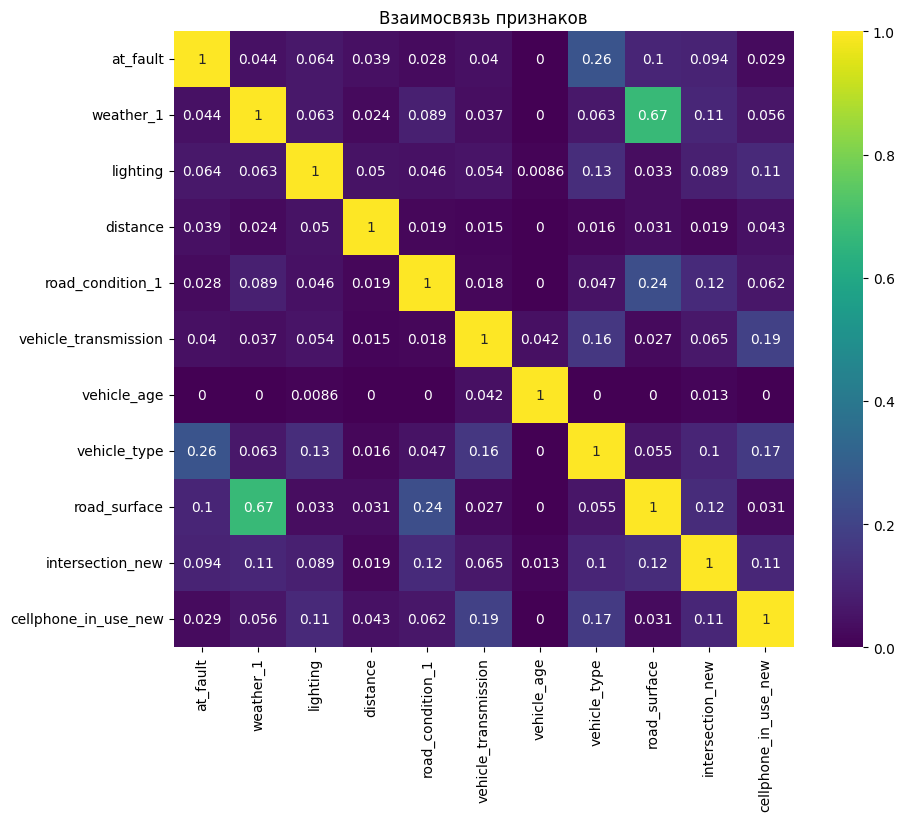

In [212]:
interval_cols = ['distance', 'vehicle_age']
corr_matrix = data_important.phik_matrix(interval_cols=interval_cols)
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='viridis')
plt.title('Взаимосвязь признаков')
plt.show()

*Итак, мультиколлинеарности между признаками и целевой переменной нет, значит, нет утечки.*

##### Рассмотрим диаграмму рассеяния.

In [213]:
data_important.columns

Index(['at_fault', 'weather_1', 'lighting', 'distance', 'road_condition_1',
       'vehicle_transmission', 'vehicle_age', 'vehicle_type', 'road_surface',
       'intersection_new', 'cellphone_in_use_new'],
      dtype='object')

             at_fault  distance  vehicle_age
at_fault     1.000000  0.078726    -0.067443
distance     0.078726  1.000000     0.022473
vehicle_age -0.067443  0.022473     1.000000


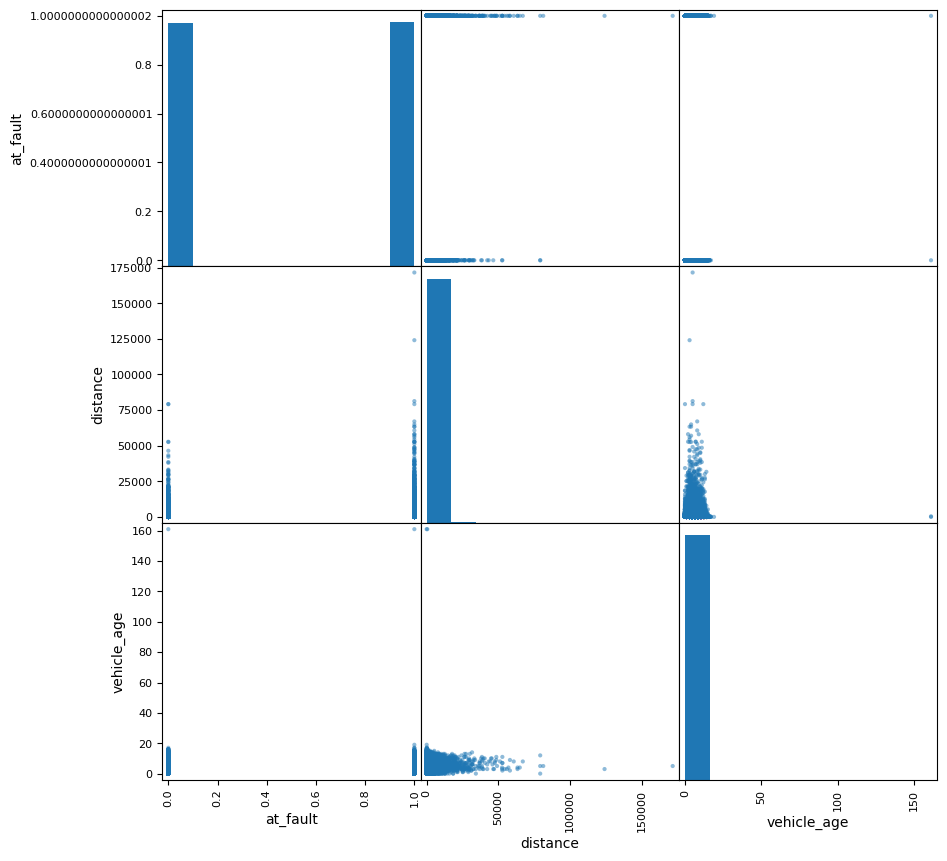

In [214]:
print(data_important[['at_fault', 'distance', 'vehicle_age']].corr())
pd.plotting.scatter_matrix(data_important, figsize=(10,10))
plt.show()

Линейной взаимосвязи между признаками не прослеживается.

##### Промежуточный вывод:
*Исследованы категориальные и количественные признаки. Многие категориальные признаки - причины ДТП, но в них есть обычно один виновный и один невиновный, виновность от них не зависит, от них зависит авария. Но можно проверить их влияние на целевое значение после построения модели и анализа важности признаков.*

*Согласно исследовательскому анализу большинство аварий случалось при благоприятных внешних уловиях: не на перекрестке, в хорошую погоду, на сухой ровной дороге дороге. Но часто причинами становилась скорость и другой автомобиль 3-х летнего возраста. Часть аварий происходи на расстоянии от главной дороги.*

*Признаки 'party_sobriety', 'vehicle_transmission' явно влияют на значение целевой переменной.*



### 5. Подготовим обучающую и тестовую выборки, проведем кодирование и масштабирование.

In [215]:
data_important.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34009 entries, 0 to 60064
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   at_fault              34009 non-null  int64  
 1   weather_1             34009 non-null  object 
 2   lighting              34009 non-null  object 
 3   distance              34009 non-null  float64
 4   road_condition_1      34009 non-null  object 
 5   vehicle_transmission  34009 non-null  object 
 6   vehicle_age           32923 non-null  float64
 7   vehicle_type          34009 non-null  object 
 8   road_surface          34009 non-null  object 
 9   intersection_new      34009 non-null  object 
 10  cellphone_in_use_new  34009 non-null  object 
dtypes: float64(2), int64(1), object(8)
memory usage: 3.1+ MB


In [216]:
X = data_important.drop('at_fault', axis=1)
Y = data_important.at_fault
print(X.shape)
print(Y.shape)

(34009, 10)
(34009,)


In [217]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    Y,
    test_size=0.25,
    shuffle=True,
    random_state=RANDOM_STATE,
    stratify = Y)
print('Размеры тренировочных данных:')
print(X_train.shape)
print(y_train.shape)
print()
print('Размеры тестовых данных:')
print(X_test.shape)
print(y_test.shape)

Размеры тренировочных данных:
(25506, 10)
(25506,)

Размеры тестовых данных:
(8503, 10)
(8503,)


In [218]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25506 entries, 23908 to 3837
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   weather_1             25506 non-null  object 
 1   lighting              25506 non-null  object 
 2   distance              25506 non-null  float64
 3   road_condition_1      25506 non-null  object 
 4   vehicle_transmission  25506 non-null  object 
 5   vehicle_age           24698 non-null  float64
 6   vehicle_type          25506 non-null  object 
 7   road_surface          25506 non-null  object 
 8   intersection_new      25506 non-null  object 
 9   cellphone_in_use_new  25506 non-null  object 
dtypes: float64(2), object(8)
memory usage: 2.1+ MB


Теперь заполним пропуски тренировочной выборки и проверим выбросы.

In [219]:
med = X_train['vehicle_age'].median()
print ('Медианный возраст автомобиля -', med)
X_train['vehicle_age'] = X_train['vehicle_age'].fillna(med)

Медианный возраст автомобиля - 5.0


In [220]:
X_test['vehicle_age'] = X_test['vehicle_age'].fillna(med)

In [221]:
print(X_train['vehicle_age'].max())

161.0


In [222]:
X_train['vehicle_age'] = X_train['vehicle_age'].apply(lambda x: x if x != 161 else med)

In [223]:
X_train.query('distance > 1500000')

,weather_1,lighting,distance,road_condition_1,vehicle_transmission,vehicle_age,vehicle_type,road_surface,intersection_new,cellphone_in_use_new


In [224]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25506 entries, 23908 to 3837
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   weather_1             25506 non-null  object 
 1   lighting              25506 non-null  object 
 2   distance              25506 non-null  float64
 3   road_condition_1      25506 non-null  object 
 4   vehicle_transmission  25506 non-null  object 
 5   vehicle_age           25506 non-null  float64
 6   vehicle_type          25506 non-null  object 
 7   road_surface          25506 non-null  object 
 8   intersection_new      25506 non-null  object 
 9   cellphone_in_use_new  25506 non-null  object 
dtypes: float64(2), object(8)
memory usage: 2.1+ MB


Итак, в тренировочной выборке пропуски заполнены. Выбросов и аномалий нет.

In [225]:
num_columns = ['distance', 'vehicle_age']

cat_columns = [] #остальные столбцы отразили как категориальные
for i in X.columns:
    if (i not in num_columns):
        cat_columns.append(i)
print('Категориальные столбцы: ',cat_columns)


Категориальные столбцы:  ['weather_1', 'lighting', 'road_condition_1', 'vehicle_transmission', 'vehicle_type', 'road_surface', 'intersection_new', 'cellphone_in_use_new']


In [226]:
 X_train_for_poly = X_train.reset_index(drop=True)
 X_test_for_poly = X_test.reset_index(drop=True)
 y_train_for_poly = y_train.reset_index(drop=True)
 y_test_for_poly = y_test.reset_index(drop=True)

In [227]:
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

In [228]:
data_preprocessor = ColumnTransformer( #подготовка данных для DecisionTree
    [('ord', ord_pipe, cat_columns),
     ('num', StandardScaler(), num_columns)
    ], remainder='passthrough').set_output(transform="pandas")

In [229]:
num_columns

['distance', 'vehicle_age']

In [230]:
cat_columns

['weather_1',
 'lighting',
 'road_condition_1',
 'vehicle_transmission',
 'vehicle_type',
 'road_surface',
 'intersection_new',
 'cellphone_in_use_new']

*Тренировочные данные предобработаны. Признаки разделены на категориальные и числовые. Все данные закодированы.*

### 6. Найдем лучшую модель.

##### Паплайн для DecisionTree

Выбрана метрика F1 по следующим соображениям.
С одной стороны необходимо точнее выявлять будущую аварию и избегать её любой ценой для того, чтобы автомобиль оставался целым, иначе уходят время на его восстановление,   и силы на его восстановление, в это время теряется выгода.
С другой стороны, если авария предсказана неверно, компания упускает выгоду из-за простоя автомобиля. Ни ошибка 1-го, ни ошибка второго рода недопустимы.
Поэтому лучшей метрикой будет гармоничное сочетание precision и recall.

In [231]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2,5),
        'models__max_features': range(2,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }

]

In [232]:
f1 = make_scorer(f1_score)

In [233]:
grid_search_dt = GridSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    scoring=f1,
    n_jobs=-1
)
grid_search_dt.fit(X_train, y_train)

model_tree = grid_search_dt.best_estimator_
metric_tree = grid_search_dt.best_score_

print('Лучшая модель и её параметры:\n\n', model_tree)
print ('Метрика на кросс-валидации тренировочной выборки:', metric_tree)

/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan)),
                                                                  ('simpleImputer_after_ord',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['weather_1', 'lighting',
                                      

##### CatBoost

In [234]:

model = CatBoostClassifier(
    cat_features=cat_columns,
    silent=True,
    early_stopping_rounds=50,
    random_state=RANDOM_STATE
)


param_dist = {
    'iterations': [100, 200, 300],
    'depth': randint(3, 8),
    'learning_rate': [0.01, 0.05, 0.1],
    'l2_leaf_reg': [1, 3, 5, 7]
}


random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=20,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1,
    random_state=RANDOM_STATE
)

random_search.fit(X_train, y_train)

metric_boost = random_search.best_score_
best_param_boost = random_search.best_params_
model_boost = random_search.best_estimator_

print(f"Лучшие параметры: {best_param_boost}")

print ('Метрика на кросс-валидации тренировочной выборки:', metric_boost)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Лучшие параметры: {'depth': 6, 'iterations': 100, 'l2_leaf_reg': 1, 'learning_rate': 0.05}
Метрика на кросс-валидации тренировочной выборки: 0.645204933585342


##### Нейросеть

In [235]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25506 entries, 23908 to 3837
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   weather_1             25506 non-null  object 
 1   lighting              25506 non-null  object 
 2   distance              25506 non-null  float64
 3   road_condition_1      25506 non-null  object 
 4   vehicle_transmission  25506 non-null  object 
 5   vehicle_age           25506 non-null  float64
 6   vehicle_type          25506 non-null  object 
 7   road_surface          25506 non-null  object 
 8   intersection_new      25506 non-null  object 
 9   cellphone_in_use_new  25506 non-null  object 
dtypes: float64(2), object(8)
memory usage: 2.1+ MB


In [236]:
scaler = StandardScaler() #кодируем и масштабируем
scaler.fit(X_train[num_columns])
X_train_scaled = scaler.transform(X_train[num_columns])
X_test_scaled = scaler.transform(X_test[num_columns])
X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_columns)

oh_encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
oh_encoder.fit(X_train[cat_columns])
encoder_cat_names = oh_encoder.get_feature_names_out()
X_train_ohe = oh_encoder.transform(X_train[cat_columns])
X_test_ohe= oh_encoder.transform(X_test[cat_columns])
X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_cat_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_cat_names)

X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

feature_names = X_train.columns.tolist()

display(X_train.head(3))
y_train

,weather_1_cloudy,weather_1_fog,weather_1_other,weather_1_raining,weather_1_snowing,weather_1_wind,lighting_dark with street lights,lighting_dark with street lights not functioning,lighting_daylight,lighting_dusk or dawn,...,vehicle_type_other,vehicle_type_sedan,road_surface_slippery,road_surface_snowy,road_surface_wet,intersection_new_yes,cellphone_in_use_new_unknown,cellphone_in_use_new_was used,distance,vehicle_age
0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.325261,-0.691714
1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.259253,0.887347
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.167028,0.887347


,at_fault
23908,1
42676,1
5523,1
7080,0
40606,0
...,...
33454,0
28048,0
2663,0
43568,1


Надо проверить количество значений в X_train.

In [237]:
print(X_train.shape)
print(y_train.shape)
print()
print('Размеры тестовых данных:')
print(X_test.shape)
print(y_test.shape)

(25506, 31)
(25506,)

Размеры тестовых данных:
(8503, 31)
(8503,)


In [238]:

y_train = torch.FloatTensor(y_train.values)
y_test = torch.FloatTensor(y_test.values)

X_train = torch.FloatTensor(X_train.values)
X_test = torch.FloatTensor(X_test.values)


print(X_train[:5], y_train[:5])
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

tensor([[ 0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,
          0.0000,  1.0000,  0.0000,  0.0000,  0.0000, -0.3253, -0.6917],
        [ 1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  1.0000,  0.0000, -0.2593,  0.8873],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,
          0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.1670,  0.8873],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000

In [239]:
torch.save(y_train, "y_train.pt")
torch.save(y_test, "y_test.pt")
torch.save(X_train, "X_train.pt")
torch.save(X_test, "X_test.pt")


In [240]:
n_in_neurons = 31 #44 #48
n_hidden_neurons_1 = 128
n_hidden_neurons_2 = 64
n_hidden_neurons_3 = 64



In [241]:
class Net_base(nn.Module):
    def __init__(self, i = 0):
        super(Net_base, self).__init__()
        self.i=i

        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.act1=nn.Tanh()
        if self.i !=  0:
            #пока нейросеть без регуряризации. В архитектуре предусмотрим включение регуляриции при необходимости
            self.dp1 = nn.Dropout(p=i)
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.act2=nn.ReLU()

        self.fc3 = nn.Linear(n_hidden_neurons_2, n_hidden_neurons_3)
        self.act3=nn.Tanh()
        self.fc4 = nn.Linear(n_hidden_neurons_3, 1)
        self.act4=nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        if self.i != 0:
            x = self.dp1(x)
        x = self.fc2(x)
        x = self.act2(x)


        x = self.fc3(x)
        x = self.act3(x)

        x = self.fc4(x)
        x = self.act4(x)
        return x

In [242]:
net_base = Net_base(i=0)
print(net_base)

Net_base(
  (fc1): Linear(in_features=31, out_features=128, bias=True)
  (act1): Tanh()
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (act2): ReLU()
  (fc3): Linear(in_features=64, out_features=64, bias=True)
  (act3): Tanh()
  (fc4): Linear(in_features=64, out_features=1, bias=True)
  (act4): Sigmoid()
)


Перебираем параметры нейросети и проводим кросс-валидацию.

In [243]:
loss = nn.BCELoss()
learning_rates = [0.00001, 0.0001]
batch_sizes = [64, 128]
pn =[0.1, 0.5]
epochs = 100
accumulation_iteration = 2

neyr()
row = []
mat=[]
best_metrics = 0.64

kfold = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

for j in pn:
    for lrate in learning_rates:
        for bs in batch_sizes:
            print(f"\nParams: pn={j}, lr={lrate}, bs={bs}")

            # KFold кросс-валидация
            for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train)):
                print(f"\nFold {fold + 1}/{kfold.n_splits}")

                # Разделение данных на тренировочную и валидационную части
                X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
                y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

                # Создание модели и оптимизатора для каждого фолда
                net = Net_base(i=j)
                optimizer = optim.Adam(net.parameters(), lr=lrate)
                num_batches = ceil(len(X_train_fold) / bs)

                for epoch in range(epochs):
                    # Обучение на train_fold
                    net.train()
                    order = np.random.permutation(len(X_train_fold))
                    for batch_i in range(num_batches):
                        start_index = batch_i * bs
                        batch_indexes = order[start_index : start_index + bs]
                        X_batch = X_train_fold[batch_indexes]
                        y_batch = y_train_fold[batch_indexes]

                        optimizer.zero_grad()
                        preds = net(X_batch)
                        loss_value = loss(preds, y_batch.view(-1, 1)) / accumulation_iteration
                        loss_value.backward()

                        if ((batch_i + 1) % accumulation_iteration == 0) or (batch_i + 1 == num_batches):
                            optimizer.step()
                            optimizer.zero_grad()

                    # Оценка на val_fold каждые 10 эпох
                    if epoch % 10 == 0:
                        net.eval()
                        with torch.no_grad():
                            random.seed(42)
                            np.random.seed(42)
                            torch.manual_seed(42)
                            torch.cuda.manual_seed_all(42)
                            val_preds = net(X_val_fold)
                            y_pred = (val_preds > 0.5).float().cpu().numpy()
                            y_true = y_val_fold.cpu().numpy()
                            f1 = f1_score(y_true, y_pred)

                            print(f"Epoch {epoch}: Val F1 = {f1:.4f}")
                            row = [epoch, j, lrate, bs, fold, f1]
                            mat.append(row)

                            if f1 > best_metrics:
                                best_metrics = f1
                                torch.save(net.state_dict(), 'best_model_.pth')


Params: pn=0.1, lr=1e-05, bs=64

Fold 1/5
Epoch 0: Val F1 = 0.0174
Epoch 10: Val F1 = 0.5780
Epoch 20: Val F1 = 0.5869
Epoch 30: Val F1 = 0.6014
Epoch 40: Val F1 = 0.6119
Epoch 50: Val F1 = 0.6190
Epoch 60: Val F1 = 0.6248
Epoch 70: Val F1 = 0.6273
Epoch 80: Val F1 = 0.6291
Epoch 90: Val F1 = 0.6282

Fold 2/5
Epoch 0: Val F1 = 0.6662
Epoch 10: Val F1 = 0.6139
Epoch 20: Val F1 = 0.6170
Epoch 30: Val F1 = 0.6271
Epoch 40: Val F1 = 0.6364
Epoch 50: Val F1 = 0.6432
Epoch 60: Val F1 = 0.6460
Epoch 70: Val F1 = 0.6495
Epoch 80: Val F1 = 0.6509
Epoch 90: Val F1 = 0.6513

Fold 3/5
Epoch 0: Val F1 = 0.6737
Epoch 10: Val F1 = 0.5970
Epoch 20: Val F1 = 0.6051
Epoch 30: Val F1 = 0.6123
Epoch 40: Val F1 = 0.6141
Epoch 50: Val F1 = 0.6164
Epoch 60: Val F1 = 0.6238
Epoch 70: Val F1 = 0.6291
Epoch 80: Val F1 = 0.6301
Epoch 90: Val F1 = 0.6307

Fold 4/5
Epoch 0: Val F1 = 0.6599
Epoch 10: Val F1 = 0.5926
Epoch 20: Val F1 = 0.5991
Epoch 30: Val F1 = 0.6050
Epoch 40: Val F1 = 0.6092
Epoch 50: Val F1 = 0.

In [244]:
results_df = pd.DataFrame(mat, columns=["epoch", "pn", "lr", "bs", "fold", "f1"])
best_params = results_df.groupby(["pn", "lr", "bs"])["f1"].mean().idxmax()

best_epoch_f1 = results_df.groupby(["pn", "lr", "bs", "fold"])["f1"].max().reset_index()

# Средний F1 по всем фолдам (лучшие эпохи)
mean_f1_best_epoch = best_epoch_f1.groupby(["pn", "lr", "bs"])["f1"].mean().reset_index()

best_params_best_epoch = mean_f1_best_epoch.loc[mean_f1_best_epoch["f1"].idxmax()]
print("\nЛучшая комбинация (по лучшим эпохам):")
print(best_params_best_epoch)


Лучшая комбинация (по лучшим эпохам):
pn     0.500000
lr     0.000010
bs    64.000000
f1     0.661098
Name: 4, dtype: float64


Получены параметры нейросети по итогам кросс-валидации и перебора параметров.

#### Сравнительная таблица моделей.

In [245]:
pd.DataFrame([
    ['DecisionTreeClassifier)', round(metric_tree,4)],
    ['CatBoostClassifier', round(metric_boost,4)],
    ['Четерехслойная нейросеть', round(best_params_best_epoch['f1'],4).item()]
],
             columns = ['модель', 'метрика F1 на тренировочных данных'])

,модель,метрика F1 на тренировочных данных
0,DecisionTreeClassifier),0.6787
1,CatBoostClassifier,0.6452
2,Четерехслойная нейросеть,0.6611


Лучшая модель - дерево решений с параметрами max_depth=3, max_features=3. Модель показала метрику - F1 =0,68.

Найдем метрику модели на тестовых данных.

Проверим метрику на тестовых данных, зафиксированных ранее, до превращения в тензоры на этапе подготовки.

In [246]:

y_test_pred = grid_search_dt.predict(X_test_for_poly)

f1_test = f1_score(y_test_for_poly, y_test_pred)
print(f"Метрика на тестовых данных F1 = {f1_test:.2f}")

Метрика на тестовых данных F1 = 0.68


<h2> Комментарий студента <a class="tocSkip"> </h2>

*Да, исправляю.*
</div>

In [247]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
y_pred = dummy_clf.predict(X_test)
f1_d = f1_score(y_test, y_pred)

print(f"Метрика на тестовых данных F1 = {f1_d:.2f}")

Метрика на тестовых данных F1 = 0.67


Метрика полученной в ходе исследования 0.68 модели превышает метрику DummyClassifier 0.67. А значит, имеет право на существование и совершенствование.

## Проведите анализ важности факторов ДТП

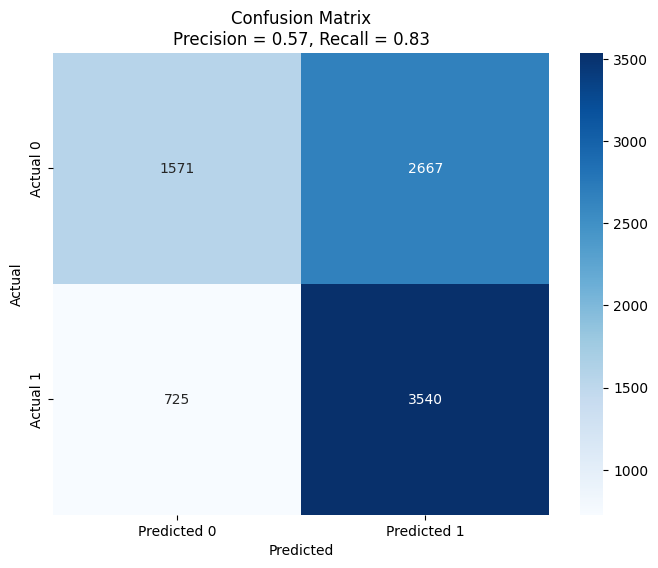

In [248]:
# Вычисляем матрицу ошибок
#y_true = y_test.numpy()
#y_pred = predicted_labels.numpy()
cm = confusion_matrix(y_test_for_poly, y_test_pred)
precision = precision_score(y_test_for_poly, y_test_pred)
recall = recall_score(y_test_for_poly, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title(f'Confusion Matrix\nPrecision = {precision:.2f}, Recall = {recall:.2f}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

*Матрица ошибок говорит о том, что:*
1. *Из 8503 значений, модель правильно предсказала 1571 отрицательных классов (True Negative), т. е. правильно предсказала невиновность участника ДТП.*
2. *Модель правильно предсказала 3540 положительных классов (True Negativ), т. е. Правильно предсказала виновность участника ДТП.*
3. *Сравнительно большое число ошибок False Positive, ошибок первого рода , то есть невиновных, которых модель определила виновными, 2667.*
4. *Ошибок второго рода, False Negative, мало, 725.*

*Модель чаще совершает ошибки 1-го рода. Об этом говорит и точность модели (precision) - 0,57.  Значит, модель часто не права в том, что участник действительно виновен.*

*При этом полнота модели высокая (recall = 0,83). То есть 83% виновных модель обнаруживает.*

In [249]:
best_pipeline = grid_search_dt.best_estimator_

models = best_pipeline.named_steps['models']

In [250]:
importances = models.feature_importances_


In [251]:
preprocessor = best_pipeline.named_steps['preprocessor']

feature_names = preprocessor.get_feature_names_out()


In [252]:
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
    }).sort_values('Importance', ascending=False)

print(feature_importance)

                     Feature  Importance
4          ord__vehicle_type    0.807244
9           num__vehicle_age    0.160759
6      ord__intersection_new    0.027631
3  ord__vehicle_transmission    0.003533
2      ord__road_condition_1    0.000833
0             ord__weather_1    0.000000
1              ord__lighting    0.000000
5          ord__road_surface    0.000000
7  ord__cellphone_in_use_new    0.000000
8              num__distance    0.000000


Самые важные факторы модели: тип кузова, возраст машины, перекресток/неперекресток, тип КПП, дорожное состояние.

### Дополнительное исследование для фактора "категории нарушения".

Изучим один из факторов - возраст автомобиля.

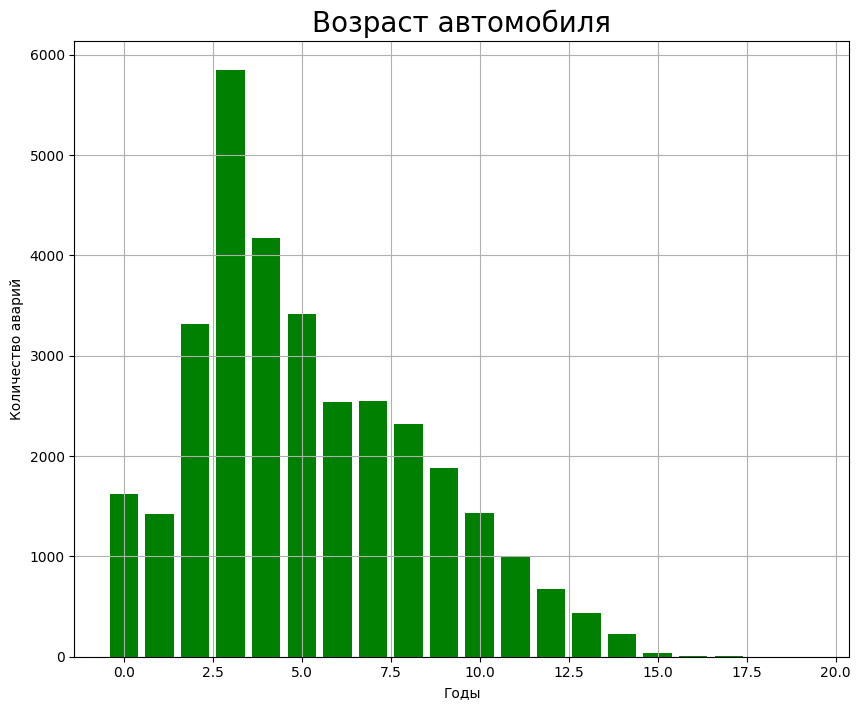

In [253]:
data_important_clear = data_important.query('vehicle_age < 161')
v1 = data_important_clear.vehicle_age.value_counts()
plt.bar(v1.index, v1, color = 'green')
plt.grid(True)
plt.xlabel("Годы")
plt.ylabel("Количество аварий")
plt.title("Возраст автомобиля", fontsize=20);

In [254]:
print('Время выполнения кода',round((time.time() - start_1)/60,2), 'минут')

Время выполнения кода 44.53 минут


Чаще всего попадают в аварию автомоибили 2-5 лет (более 21 тыс.), больше всего трех лет. Видимо, к этому времени автомобиль изнашивается и требует капитальный ремонт. К 6-ти годам большинство автомобилей отремонтированы или благодаря качественному содержанию и своевременному осмотру не допускают аварий.

Этот фактор нужно учитывать, выводя автомобиль из гаража. Владельцу автомобилей необходимо обратить внимание, что даже новый автомоиль уже в два года, а лучше раньше, требует качественного обслуживания, своевременно проводить техосмотр и контролировать исправность всех детелей и узлов.

## Выводы

Набор данных согласно техзаданию составляет ту часть исторических данных, где тип виновника только машина (если не виновник, то может быть не машина); повреждения любые кроме царапин; данные за 2012 г.

Для подготовки модели предсказния ДТП были выбраны следующие признаки: перекресток/неперекресток, погода, состояние дороги,  освещение, категория нарушения,  дорожное состояние, состояние водителя, наличие телефона с громкой связью, тип КПП, возраст машины, расстояние до главной дороги.

Данные были предобработаны, удалены дубликаты, устранены многичесленные пропуски, в модель взяты только те признаки, пропуски в которых могли быть заполнены или устранены другим способом без вреда для модели. Проведено исследование. Удален один выброс. Исследована зависимость между признаками.

Обучена нейросеть из четерых слоев, в которой найдены лучшие параметры перебром скорости, параметра dropout, размера батчей. F1 на этой модели достигла  0.68. Модель неточная, но на 83% определяет всех виновных. Значит, модель не досточно качественная, требует существенной доработки. Модель лучше выявляет ошибки второго .

Самыми важными фактора аварий выявлена тип кузова, возраст автомобиля, перекресток/неперекресток, тип КПП.

Всё-таки спобность модели оценивать риск недостаточно высок. Поэтому создание адекватной системы оценки риска при выдаче автомобиля на текущий момент невозможен. `Много факторов косвенно влияющих на риск ДТП и слишком мало непосредственно влияющих и воспроизводимых.` Но останавливаться и заканчивать попытки не стоит. Возможно стоит также учитывать факторы: пол (женщины , возможно, аккуратнее водят автомоибиль), наличие детей в машине (водитель с детьми, возможно внимательнее относится к правилам на дороге), знание ПДД также бы помогло снизить вероятность ДТП (допустим, пароль к системе - это правильный ответ на вопрос по ПДД). Один из важных факторов - это уважение водителей к друг другу, для его измерения понадобится психолог.
